#Set up

In [27]:
# !pip3 freeze > requirements.txt
# !pip install pipreqs

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.3/798.3 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.4/257.4 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 49.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.0/48.0 kB 7.9 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=923f00f0e7536161aef81bd0aabf760c208733f2a581949a2b524bdf42bdc668
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt
  Attempting uninstall: mistune
    Found existing installation: mistune 0.8.4
    Uninstalling mistune-0.8.4:
      Successfully uninstalled mistune-0.8.4
  Attempting uninstall: ipython
    Found existing installation: ipython 7.34.0
    Uninstalling ipython-7.34.0:
      Successfully uninstalled ipython-7.34.0
  Attempting uninstall: nbconver

In [25]:
import numpy as np
import copy
from scipy.optimize import minimize_scalar
# import scipy.special.lambertw as lambertw
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import pandas as pd
import seaborn as sns
import collections
import math
import os
import datetime
import matplotlib.dates as mdates
import pandas as pd

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
# plot set up
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [28]:
FEDERAL_COLOR = 'tab:blue'
state_color = 'tab:orange'
county_color = ['tab:green', 'tab:red', 'tab:brown', 'tab:pink','tab:olive']
PATH = '/content/drive/MyDrive/Research/PolicySIR/figure'

!pip install ipython-autotime
%load_ext autotime

time: 2.09 ms (started: 2024-07-15 13:56:45 +00:00)


# Functions

## SIR functions

In [29]:
def deterministic_sir(beta, gamma, n, T, i0, s0=None,policy=1,h=1):
# Compute susceptible population, set recovered to zero
  if s0 == None:
    S = [n - i0*n]
  else:
    S = [s0*n]
  I = [i0*n]
  R = [n - S[-1] - I[-1]]
  # print(S,I,R)
  m = int(1/h)
  for i in range(1,int(T/h)):
    st = S[-1]
    it = I[-1]
    rt = R[-1]
    # print(i)
    if it <= 0:
      break
    S.append(st - policy*h*(beta * st * it/ n))
    I.append(it + h*(policy*beta * st * it / n - gamma * it))
    R.append(rt + h*gamma * it)
    # print('from S',policy*beta * st * it / n)



  return S, I, R
  # return S[::m], I[::m], R[::m]

time: 1.44 ms (started: 2024-07-15 13:56:45 +00:00)


In [30]:
def update_compartment(S,I,R, ks, ki, kr, delta_t=1):
  S_new, I_new, R_new = np.zeros_like(S),np.zeros_like(I),np.zeros_like(R)
  for i in range(len(S)):
    # print(S*ks[i].shape)
    # print(S.shape)
    # print(ks.shape)
    # print(ks[i].shape)
    S_new[i] = np.dot(S, ks[i]) - np.sum(S[i]*ks[:,i]) + S[i]*ks[i,i]
    I_new[i] = np.dot(I, ki[i]) - np.sum(I[i]*ki[:,i]) + I[i]*ki[i,i]
    R_new[i] = np.dot(R, kr[i]) - np.sum(R[i]*kr[:,i]) + R[i]*kr[i,i]
  return S_new,I_new,R_new

time: 5.13 ms (started: 2024-07-15 13:56:45 +00:00)


In [31]:
def update_SIR(S,I,R, policy,county_pop, beta, gamma,h=1/3):
  for i in range(int(1/h)):
    if I < 1:
      I = 0
    S_temp = S
    I_temp = I
    R_temp = R
    S = S - policy * beta * S * I/county_pop * h
    I = I_temp + policy * beta * S_temp * I_temp/county_pop*h - gamma * I_temp* h
    R = R_temp + gamma * I_temp*h
  return S,I,R

time: 2.88 ms (started: 2024-07-15 13:56:45 +00:00)


In [32]:
def update_network_SIR(S,I,R, policy, county_pop, K, beta, gamma):
  S_new, I_new, R_new = np.zeros_like(S,dtype=float),np.zeros_like(I,dtype=float),np.zeros_like(R,dtype=float)
  for i in range(len(S)):
    if I[i] < 1:
      I[i] = 0
    S_new[i] = S[i] - policy[i] * beta * S[i] * np.dot(I, K[i])/county_pop[i]
    I_new[i] = I[i] + policy[i] * beta * S[i] * np.dot(I, K[i])/county_pop[i] - gamma*I[i]
    # print(I_new[i])

    R_new[i] = R[i] + gamma*I[i]
    # print(policy[i] * beta * S[i] * np.dot(I, K[i])/county_pop[i])
    # print(gamma*I[i])
    # print(R[i] + gamma*I[i])
    # print(R_new[i])
    # if S_new[i] + I_new[i] + R_new[i] != county_pop[i]:
    #   print('POPULATION NOT EQUAL!')

  # S_new, I_new, R_new = [],[],[]
  # for i in range(len(S)):
  #   # if I[i] <= 0:
  #   #   break
  #   S_new.append(S[i] - policy[i] * beta * S[i] * np.dot(I, K[i])/county_pop[i])
  #   I_new.append(I[i] + policy[i] * beta * S[i] * np.dot(I, K[i])/county_pop[i] - gamma*I[i])
  #   # print(I_new[i])

  #   R_new.append(R[i] + gamma*I[i])
  #   # print(policy[i] * beta * S[i] * np.dot(I, K[i])/county_pop[i])
  #   # print(gamma*I[i])
  #   print(R_new[-1])
  #   if S_new[i] + I_new[i] + R_new[i] != county_pop[i]:
  #     print('POPULATION NOT EQUAL!')
  return S_new,I_new,R_new


time: 1.4 ms (started: 2024-07-15 13:56:46 +00:00)


In [33]:
def update_SIR_infinity(S0,I0,county_pop, beta, gamma):
  S =[S0]
  I = [I0]
  R = [county_pop - S0 - I0]
  h=1
  while I[-1] > 1:
    S.append(S[-1] - h*(beta * S[-1] * I[-1] / county_pop))
    I.append(I[-1] + h*(beta * S[-1] * I[-1] / county_pop - gamma * I[-1]))
    R.append(R[-1] + h*gamma * I[-1])
  return S, I, R

time: 1.09 ms (started: 2024-07-15 13:56:46 +00:00)


In [34]:
# S = S - policy * beta * S * I/county_pop # dt = 1
# I = I + policy * beta * S * I/county_pop - gamma * I
# R = R + gamma * I
def dSdt(t, S, I, policy, county_pop, beta):
    return - policy * beta * S * I/county_pop
def dIdt(t, S, I, policy, county_pop, beta, gamma):
    return policy * beta * S * I/county_pop - gamma * I
def dRdt(t, I, gamma):
    return gamma * I
# Finds value of y for a given x using step size h
# and initial value y0 at x0.
def rungeKutta(t0, I0, S0, R0, county_pop, policy, beta=0.3, gamma=0.07, delta_t=1, h=1/10):
    # Count number of iterations using step size or
    # step height h
    t = delta_t + t0
    n = int((t - t0)/h)
    # Iterate for number of iterations
    S = S0
    I = I0
    R = R0
    for i in range(1, n + 1):
        "Apply Runge Kutta Formulas to find next value of y"
        k1s = h * dSdt(t0, S, I, policy, county_pop, beta)
        k1i = h * dIdt(t0, S, I, policy, county_pop, beta, gamma)
        k1r = h * dRdt(t0, I, gamma)

        k2s = h * dSdt(t0 + 0.5 * h, S + 0.5 * k1s, I + 0.5 * k1i, policy, county_pop, beta)
        k2i = h * dIdt(t0 + 0.5 * h, S + 0.5 * k1s, I + 0.5 * k1i, policy, county_pop, beta, gamma)
        k2r = h * dRdt(t0 + 0.5 * h, I + 0.5 * k1i, gamma)

        k3s = h * dSdt(t0 + 0.5 * h, S + 0.5 * k2s, I + 0.5 * k2i, policy, county_pop, beta)
        k3i = h * dIdt(t0 + 0.5 * h, S + 0.5 * k2s, I + 0.5 * k2i, policy, county_pop, beta, gamma)
        k3r = h * dRdt(t0 + 0.5 * h, I + 0.5 * k2i, gamma)

        k4s = h * dSdt(t0 + h, S + k3s, I + k3i, policy, county_pop, beta)
        k4i = h * dIdt(t0 + h, S + k3s, I + k3i, policy, county_pop, beta, gamma)
        k4r = h * dRdt(t0 + h, I + k3i, gamma)

        # Update next value of S, I, R
        S = S + (1.0 / 6.0)*(k1s + 2 * k2s + 2 * k3s + k4s)
        I = I + (1.0 / 6.0)*(k1i + 2 * k2i + 2 * k3i + k4i)
        R = R + (1.0 / 6.0)*(k1r + 2 * k2r + 2 * k3r + k4r)
        # Update next value of x
        t0 = t0 + h
    return S,I,R

time: 2.46 ms (started: 2024-07-15 13:56:46 +00:00)


In [35]:
def network_sir(beta, gamma, T, i0,
                county_pop=[100,100,100,100],
                county_area = [10,10,10,10],
                p1=1,p2=1,dt=1,
                K = None):
  # counties in the game, network SIR
  # Number of nodes in the physical layer
  t = 0
  n_county = len(county_pop)
  n_state = 1
  county_policy =[1]*4

  I = np.zeros((n_county,T))
  S = np.zeros((n_county,T))
  R = np.zeros((n_county,T))

  # Transportation rate matrix
  if not isinstance(K,np.ndarray):
    K = 0.001*np.ones((n_county,n_county))
    # a = np.zeros_like(K)
    np.fill_diagonal(K, 1)
    # K = K - a

  print('Excitation matrix:', K)
  if isinstance(i0,float):
    for i in range(n_county):
      I[i][0] = i0*county_pop[i]
      S[i][0] = (1-i0)*county_pop[i]
  else:
    for i in range(n_county):
      I[i][0] = i0[i]*county_pop[i]
      S[i][0] = (1-i0[i])*county_pop[i]

  for t in range(1,T):
    for i in range(n_county):
      # if I[i][t-1] <= 0:
      #   break # TODO: how to deal with this edge case?

      S[:,t],I[:,t],R[:,t]  = update_network_SIR(S[:,t-1], I[:,t-1],R[:,t-1], county_policy, county_pop, K, beta=beta, gamma=gamma)

  return S,I,R

time: 1.7 ms (started: 2024-07-15 13:56:46 +00:00)


##  Cost functions

In [36]:
# def cost(alpha, S, I, N, alpha_prev, beta, gamma, kappa = 1/3, eta = 1/3, two_sided=False):
#   if two_sided:
#      return kappa*(1 - alpha) + eta*alpha*beta*S*I/N + (1 - kappa - eta)*max(0,alpha - alpha_prev)**2
#   else:
#     cost = kappa*(1 - alpha) + eta*alpha*beta*S*I/N + (1 - kappa - eta)*(alpha - alpha_prev)**2
#   return cost

def cost(alpha, S, I, N, alpha_prev, beta, gamma, kappa = 1/3, eta = 1/3, two_sided=False):
# impact cost is the asymptotic solution of r
  R0 = alpha*beta/gamma
  if two_sided:
     return kappa*(1 - alpha) + eta*(1+1/R0*lambertw(-S/N*R0*math.exp(-R0*(S+I)/N))) + (1 - kappa - eta)*(alpha - alpha_prev)**2
  else:
    return kappa*(1 - alpha) + eta*(1+1/R0*lambertw(-S/N*R0*math.exp(-R0*(S+I)/N)))+ (1 - kappa - eta)*max(0,alpha - alpha_prev)**2

# def cost_density(alpha,S, I, N, A, alpha_prev, beta, gamma,kappa = 1/3, eta = 1/3, two_sided=False):
# use daily increase for impact cost
#   R = N - S - I
#   if two_sided:
#      return kappa*(1 - alpha) + eta * (alpha * beta * S * I/N - gamma*I)/(N*A) +(1 - kappa - eta)*(alpha - alpha_prev)**2
#   else:
#     return kappa*(1 - alpha) + eta* (alpha * beta * S * I/N - gamma*I)/(N*A) +(1 - kappa - eta)*max(0,alpha - alpha_prev)**2


# def cost_density(alpha,S, I, N, A, alpha_prev, beta, gamma,kappa = 1/3, eta = 1/3, two_sided=False):
# #using lambertw function for final pandemic size for impact cost, issue with complex number
#   R0 = alpha*beta/gamma
#   if two_sided:
#      return kappa*(1 - alpha) + eta * (1+1/R0*lambertw(-S/N*R0*math.exp(-R0*(S+I)/N)))/A +(1 - kappa - eta)*(alpha - alpha_prev)**2
#   else:
#     return kappa*(1 - alpha) + eta* (1+1/R0*lambertw(-S/N*R0*math.exp(-R0*(S+I)/N)))/A +(1 - kappa - eta)*max(0,alpha - alpha_prev)**2

def cost_density(alpha,S, I, N, A, alpha_prev, t,t_prev,beta, gamma,kappa = 1/3, eta = 1/3, two_sided=False):
# using lambertw function for final pandemic size for impact cost, issue with complex number
  _, _, R = deterministic_sir(alpha*beta, gamma,N, 100,I/N,S/N)
  Re = R[-1]
  if two_sided:
     return kappa*(1 - alpha)*(t-t_prev)/90 + eta * Re/(A) +(1 - kappa - eta)*(alpha - alpha_prev)**2
  else:
    return kappa*(1 - alpha)*(t-t_prev)/90  + eta* Re/(A) +(1 - kappa - eta)*max(0,alpha - alpha_prev)**2


def cost_density_constant(alpha, S, I, N, A, alpha_prev, beta, gamma, ts = 30, te = 60, kappa = 1/3, eta = 1/3, two_sided=False):
# using lambertw function for final pandemic size for impact cost, issue with complex number
  _, _, R = deterministic_sir(alpha*beta, gamma,N, 100,I/N,S/N)
  Re = R[-1]
  if two_sided:
     return kappa*(1 - alpha)*(ts-te) + eta * Re/(A) +(1 - kappa - eta)*(alpha - alpha_prev)**2*(ts-te)
  else:
    return kappa*(1 - alpha)*(ts-te) + eta* Re/(A) +(1 - kappa - eta)*max(0,alpha - alpha_prev)**2*(ts-te)

# NYC: 27000/sq mi
# LA county: 2,100/sq mi (810/km2)
# NYC = 12.8*LA

time: 4.39 ms (started: 2024-07-15 13:56:46 +00:00)


In [37]:
def min_cost(f):
  res = minimize_scalar(f, bounds =(0,1), method='bounded')
  # print(res.message)
  # print('cost = ', f(res.x))
  return res.x

time: 557 µs (started: 2024-07-15 13:56:46 +00:00)


## Plotting functions

In [38]:
def show_policy(T,policys,title = 'policy'):
  plt.figure()
  plt.plot([t for t in range(T-1)],policys)
  plt.title(title)
  plt.xlabel('Days')
  plt.ylabel(r'$\alpha$')

def show_all_policy(T,federal_policys, state_policys, county_policys, title = 'Policy'):
  plt.figure(figsize = (8,6))
  plt.plot([t for t in range(T-1)],federal_policys, label = 'federal', linestyle = 'dashdot')
  for i in range(len(state_policys[0])):
    plt.plot([t for t in range(T-1)], [state_policys[t][i] for t in range(T-1)],label = 'state '+str(i+1), linestyle = 'dashed')
  for i in range(len(county_policys[0])):
    plt.plot([t for t in range(T-1)],[county_policys[t][i] for t in range(T-1)], label = 'county '+str(i+1))

  plt.title(title)
  plt.ylim((-0.1,1.1))
  plt.legend()

def show_effective_r(T,policys, beta, gamma):
  plt.plot([t for t in range(T-1)],[policy*beta/gamma for policy in policys])
  plt.title('effective R_0')


def plot_federal_policy_fun(T,policys, beta, gamma):
  plt.plot([t for t in range(T-1)],[policy*beta/gamma for policy in policys])
  plt.title('effective R_0')

time: 2.05 ms (started: 2024-07-15 13:56:46 +00:00)


## Updating policy functions

In [39]:
def update_policy(S,I,N, alpha_prev, beta, gamma, kappa = 1/3,eta=1/3, two_sided=False):
  f = lambda alpha: cost(alpha, S, I, N, alpha_prev, beta, gamma, kappa = kappa,eta=eta, two_sided=two_sided)
  updated_alpha = min_cost(f)
  return updated_alpha

def update_policy_density(S, I, N, A, alpha_prev, t,t_prev, beta, gamma, kappa = 1/3,eta=1/3, two_sided=False):
  f = lambda alpha: cost_density(alpha, S, I, N, A, alpha_prev, t,t_prev,beta, gamma, kappa = kappa,eta=eta, two_sided=two_sided)
  updated_alpha = min_cost(f)
  return updated_alpha

def update_state_policy_density(S, I, N, A, alpha_prev, t, t_prev, beta, gamma, policys = [.2, .4,.6,.8], kappa = 1/3,eta=1/3, two_sided=False):
  # S: a list of S of counties that belong to the state
  # I: a list of I of counties that belong to the state
  # N: list of population density of counties that belong to the state
  # A:list of areas of counties that belong to the state
  # go over all possible combination of policies of the lower level
  n_county = len(S)
  # the code is used only when n_county = 2
  costs = np.zeros((len(policys),len(policys),len(policys)))
  for k in range(len(policys)):
    for i in range(len(policys)):
      for j in range(len(policys)):
        s_policy = policys[k]
        c1_policy = policys[i]
        c2_policy = policys[j]
        # print(s_policy)
        _, _, R = deterministic_sir(c1_policy*beta, gamma,N[0], 100,I[0]/N[0],S[0]/N[0])
        R1e = R[-1]
        _, _, R = deterministic_sir(c2_policy*beta, gamma,N[1], 100,I[1]/N[1],S[1]/N[1])
        R2e = R[-1]
        Re = R1e + R2e
        As = sum(A)

        cost = kappa*(1 - s_policy)*(t-t_prev)/90 + eta * Re/(As) +(1 - kappa - eta)*(s_policy - alpha_prev)**2

        costs[k,i,j] = cost

  r,s,t = np.unravel_index(np.argmax(costs, axis=None), costs.shape)
  # print(costs[r,s,t])

  return policys[r], policys[s], policys[t]

time: 2.25 ms (started: 2024-07-15 13:56:46 +00:00)


## Game SIR

In [40]:
def policy_game(beta, gamma, T,
                federal_policys,
                i0, i_threshold = 0.3,
                delta_t=60,
                county_pop=[100,100,100,100],
                county_area = [10,10,10,10],
                p1=1,p2=1,dt=1,
                kappa=1/3,eta=1/3,
                kappa_county = [1/3,1/2,1/3,1/3],
                eta_county = [1/3,1/4,1/3,1/3],
                K = None,
                two_sided=False,
                refresh_rate=10):
  # counties in the game, network SIR
  # uses a different federal policy function which is characterized by duration, start time, policy strength
  alpha1,alpha2, alpha3 = federal_policys

  # Number of nodes in the physical layer
  t = 0
  n_county = len(county_pop)
  n_state = 1

  state_pop = sum(county_pop)
  federal_pop = state_pop

  state_policy_all = [1]
  federal_policy_all = [1]
  county_policy_all = np.ones((T,n_county))


  I = np.zeros((n_county,T))
  S = np.zeros((n_county,T))
  R = np.zeros((n_county,T))

  # Transportation rate matrix
  if K.any() == None:
    K = 0.001*np.ones((n_county,n_county))
    # a = np.zeros_like(K)
    np.fill_diagonal(K, 1)
    # K = K - a

  print('Excitation matrix:', K)
  if isinstance(i0,float):
    for i in range(n_county):
      I[i][0] = i0*county_pop[i]
      S[i][0] = (1-i0)*county_pop[i]
  else:
    for i in range(n_county):
      I[i][0] = i0[i]*county_pop[i]
      S[i][0] = (1-i0[i])*county_pop[i]


  county_policy = np.ones(n_county)
  state_policy = np.ones(n_state)
  federal_policy = 1

  t_prev = None
  tc_prev = None

  for t in range(1,T):
    # for i in range(n_county):
      # if I[i][t-1] <= 0:
      #   break # TODO: how to deal with this edge case?

    S[:,t],I[:,t],R[:,t]  = update_network_SIR(S[:,t-1], I[:,t-1],R[:,t-1], county_policy, county_pop, K, beta=beta, gamma=gamma)
      # print(I[i][t])

    federal_policy_all.append(federal_policy)
    state_policy_all.append(np.copy(state_policy)) # need deep copy for this one!!!!!!
    county_policy_all[t] = county_policy
    # print('t:',t,'I:',np.sum(I[:,t])/federal_pop)

    if np.sum(I[:,t])/federal_pop > i_threshold and (t_prev == None or t - t_prev > delta_t):
      print('Federal policy released')
      # print('infected:',np.sum(I[:,t])/federal_pop)
      # print('t',t)
      federal_policy = alpha2
      if t_prev == None:
        t_prev = 0
      if tc_prev == None:
        tc_prev = 0
      # federal_policy,t_prev = federal_policy5(alpha1, alpha2,alpha3,t,I[i][t]/county_pop[i], i_threshold, t_prev)
      # print(federal_policy)
      # print('Strict federal policy starts. ')
      # print('day',t)
      for i in range(n_state):
        state_policy[i] = update_policy_density(np.sum(S[:,t]),
                                                np.sum(I[:,t]),
                                                state_pop,
                                                sum(county_area),
                                                federal_policy,
                                                t,t_prev,
                                                beta,gamma,
                                                kappa=kappa, eta=eta,
                                                two_sided=two_sided)

        print('state '+str(i)+' policy at day ' + str(t)+':', state_policy[i])
      # state_policy[i] = update_policy(I[2*i][t] + I[2*i+1][t], county_pop[2*i] + county_pop[2*i+1], federal_policy, kappa=kappa, eta=eta,two_sided=two_sided)
      for i in range(n_county):
        county_policy[i] = update_policy_density(S[i][t], I[i][t],
                                                county_pop[i],
                                                county_area[i],
                                                state_policy,
                                                t,t_prev,
                                                beta,gamma,
                                                kappa=kappa_county[i],
                                                 eta=eta_county[i],
                                                 two_sided=two_sided)
      t_prev = t
      tc_prev = t

    elif t_prev and t - t_prev > delta_t and federal_policy != alpha1:
        federal_policy = alpha1
        print('No Federal intervention.')
        for i in range(n_state):
          state_policy[i] = update_policy_density(np.sum(S[:,t]),
                                                  np.sum(I[:,t]),
                                                  state_pop,
                                                  sum(county_area),
                                                  federal_policy,
                                                  t,t_prev,
                                                  beta,gamma,
                                                  kappa=kappa, eta=eta,
                                                  two_sided=two_sided)
          print('state '+str(i)+' policy at day ' + str(t)+':', state_policy[i])
        # state_policy[i] = update_policy(I[2*i][t] + I[2*i+1][t], county_pop[2*i] + county_pop[2*i+1], federal_policy, kappa=kappa, eta=eta,two_sided=two_sided)
        for i in range(n_county):
          county_policy[i] = update_policy_density(S[i][t], I[i][t],
                                                  county_pop[i],
                                                  county_area[i],
                                                  state_policy,
                                                  t,t_prev,
                                                  beta,gamma,
                                                  kappa=kappa_county[i],
                                                  eta=eta_county[i],
                                                   two_sided=two_sided)
        t_prev = t
        tc_prev = t

    elif tc_prev and t - tc_prev >= refresh_rate:
      print('County update every '+str(refresh_rate)+' days:')
      for i in range(n_county):
        county_policy[i] = update_policy_density(S[i][t], I[i][t],
                                                  county_pop[i],
                                                  county_area[i],
                                                  state_policy,
                                                  t,tc_prev,
                                                  beta,gamma,
                                                  kappa=kappa_county[i],
                                                  eta=eta_county[i],
                                                  two_sided=two_sided)
      tc_prev = t
      print(county_policy)

  return S,I,R, county_policy_all, state_policy_all, federal_policy_all

time: 7.69 ms (started: 2024-07-15 13:56:46 +00:00)


In [41]:
class Node:
    def __init__(self, i0=0.1, s0=0.9, population=0,area=1,eta=1/3, kappa=1/3,IsState=True):
      # i0: list or scalar
      # population: list or scalar
      # area: list or scalar
      # kappa: list or scalar, if list, the first entry is the state kappa
      if IsState:
        self.population = sum(population)
        self.area = sum(area)
        self.I = [sum([i0[i]*population[i] for i in range(len(population))])]
        self.S = [sum([s0[i]*population[i] for i in range(len(population))])]
        self.R = [sum([(1-i0[i]-s0[i])*population[i] for i in range(len(population))])]
        self.IsState = IsState
        self.K = np.zeros((len(population),len(population)))
        np.fill_diagonal(self.K,1)

        if isinstance(kappa,float):
          kappa = [kappa]*(len(population)+1)
        if isinstance(eta,float):
          eta = [eta]*(len(population)+1)

        self.kappa = kappa[0]
        self.eta = eta[0]

        self.children = []
        for i in range(len(population)):
          self.children.append(Node(i0=i0[i],s0=s0[i],
                                    population = population[i],
                                    area=area[i],IsState=False,
                                    kappa=kappa[i+1],eta=eta[i+1]))

      else:
          self.population = population
          self.area = area
          self.I = [self.population*i0]
          self.S = [self.population*s0]
          self.R = [self.population*(1-s0-i0)]
          self.children=None
          self.IsState=False
          self.kappa = kappa
          self.eta = eta


      self.policy = [(0,1)]
      self.cost = [(0,1)]

time: 7.28 ms (started: 2024-07-15 13:56:46 +00:00)


In [42]:
from collections import defaultdict
def policy_sir_seq_v3(beta, gamma, T,
                      federal_policys,
                      i0={'0': [0.1,0.1],'1': [0.1,0.1]},
                      i_threshold = 0.3,
                      delta_t=60,
                      county_pop={'0': [100,100],'1': [100,100]},
                      county_area = {'0': [10,10],'1': [10,10]},
                      p1=1,p2=1,dt=1,
                      kappa=1/3,eta=1/3,two_sided=False):

  # version 3:
  # uses a different federal policy function which is characterized by duration, start time, policy strength
  # can be applied to states of different sizes

  # Initialize results
  n_state = len(county_pop.keys())
  res = {}
  federal_pop = 0
  f_I = 0

  for i in range(n_state):
    res[str(i)] = Node(i0=i0[str(i)],population=county_pop[str(i)],area=county_area[str(i)],IsState=True,kappa=kappa[str(i)],eta=eta[str(i)])
    federal_pop += sum(county_pop[str(i)])

  # print(federal_pop)
  alpha1,alpha2, alpha3 = federal_policys

  federal_policy_all = []
  federal_policy = 1

  t_prev = None

  for t in range(1,T):
    f_I = 0
    s_I = 0
    s_S = 0
    s_R = 0
    for i in range(n_state):

      for county in res[str(i)].children:
        if county.I[-1] <= 0:
          break # TODO: how to deal with this edge case?
        # print(county.I[-1])
        # print('beta part:',county.policy[-1] * beta * county.S[-1] * county.I[-1]/county.population)
        # print('gamma part:',gamma * county.I[-1])
        S = county.S[-1] - county.policy[-1][1] * beta * county.S[-1] * county.I[-1]/county.population
        I = county.I[-1] + county.policy[-1][1] * beta * county.S[-1] * county.I[-1]/county.population - gamma * county.I[-1]
        R = county.R[-1] + gamma * county.I[-1]
        # print('new I:',I)
        county.S.append(S)
        county.I.append(I)
        county.R.append(R)
        # print(county.I[-1])

        s_I += county.I[-1]
        s_S += county.S[-1]
        s_R += county.R[-1]

      res[str(i)].S.append(s_S)
      res[str(i)].I.append(s_I)
      res[str(i)].R.append(s_R)

      f_I += res[str(i)].I[-1]

    federal_policy_all.append(federal_policy)

    if f_I/federal_pop > i_threshold:
      # print(f_I/federal_pop)
      # print('day',t)
      if t_prev == None or t - t_prev > delta_t:
        federal_policy = alpha2
        if t_prev == None:
          t_prev = 0
        # print(federal_policy)
        # print('Strict federal policy starts. ')

        for i in range(n_state):
          state_policy = update_policy_density(res[str(i)].S[-1],
                                               res[str(i)].I[-1],
                                               res[str(i)].population,
                                               res[str(i)].area,
                                               federal_policy,
                                               t,t_prev,
                                               beta,gamma,
                                               kappa= res[str(i)].kappa,
                                               eta = res[str(i)].eta,
                                               two_sided=two_sided)
          res[str(i)].policy.append((t,state_policy))
          print('State '+str(i)+' policy at day ' + str(t)+':', state_policy)

          for county in res[str(i)].children:
            county_policy = update_policy_density(county.S[-1], county.I[-1],
                                                  county.population,
                                                  county.area,
                                                  state_policy,
                                                  t,t_prev,
                                                  beta,gamma,
                                                  kappa=county.kappa,
                                                  eta=county.eta,
                                                  two_sided=two_sided)
            county.policy.append((t,county_policy))

        t_prev = t


    else:
      if t_prev and t - t_prev > delta_t and federal_policy != alpha1:
        federal_policy = alpha1

        # print('No Federal intervention.')
        for i in range(n_state):
          state_policy = update_policy_density(res[str(i)].S[-1],
                                               res[str(i)].I[-1],
                                               res[str(i)].population,
                                               res[str(i)].area,
                                               t,t_prev,
                                               federal_policy,
                                               beta,gamma,
                                               kappa=res[str(i)].kappa,
                                               eta = res[str(i)].eta,
                                               two_sided=two_sided)
          res[str(i)].policy.append((t,state_policy))
          print('State '+str(i)+' policy at day ' + str(t)+':', state_policy)

          for county in res[str(i)].children:
            county_policy = update_policy_density(county.S[-1], county.I[-1],
                                                  county.population,
                                                  county.area,
                                                  state_policy,
                                                  t,t_prev,
                                                  beta,gamma,
                                                  kappa=county.kappa,
                                                  eta=county.eta,
                                                  two_sided=two_sided)
            county.policy.append((t,county_policy))

        t_prev = t

  return res, federal_policy_all

time: 12.5 ms (started: 2024-07-15 13:56:46 +00:00)


In [43]:
def plot_i_v3(res, T, figsize=(10,8),county_name=None, plot_state=True, percent=True,ylimit=(0,0.4),ncol=None):
  fig, ax = plt.subplots(figsize=figsize)
  time = [t for t in range(T)]
  # plt.plot([t for t in range(T)], S[0], label = 'S')
  # county_color = ['red','purple','tab:brown','tab:pink']
  # for i in range(4):
  #   plt.plot([t for t in range(T)], [x/county_pop[i] for x in I[i]], label = 'county '+ str(i+1)+', pd = '+ str(round(county_pop[i]/county_area[i],2)),color = county_color[i])
  n_state = len(res.keys())
  for i in range(n_state):
    if plot_state:
      plt.plot([t for t in range(T)],
               [x/res[str(i)].population for x in res[str(i)].I],
               label='I-state '+str(i+1),color = county_color[0])
      # plt.plot([t for t in range(T)],
      #          [x/res[str(i)].population for x in res[str(i)].S],
      #          label='S-state '+str(i+1),color = county_color[0])
      # plt.plot([t for t in range(T)],
      #          [x/res[str(i)].population for x in res[str(i)].R],
      #          label='R-state '+str(i+1),color = county_color[0])
    for j,county in enumerate(res[str(i)].children):
      if county_name:
        if percent:
          plt.plot([t for t in range(T)],[i/county.population for i in county.I],label=county_name[j])
        else:
          plt.plot([t for t in range(T)],[i for i in county.I],label=county_name[j])
      else:
        if percent:
          plt.plot([t for t in range(T)],
                   [i/county.population for i in county.I],
                   label='I-county '+str(j+1)+', state '+str(i+1)
                   ,color = county_color[j+1])
          # plt.plot([t for t in range(T)],
          #          [i/county.population for i in county.S],
          #          label='S-county '+str(j+1)+', state '+str(i+1)
          #          ,color = county_color[j+1])
          # plt.plot([t for t in range(T)],
          #          [i/county.population for i in county.R],
          #          label='R-county '+str(j+1)+', state '+str(i+1)
          #          ,color = county_color[j+1])
        else:
          plt.plot([t for t in range(T)],[i for i in county.I],label='county '+str(j+1)+', state '+str(i+1))
      # print(1+county.I.index(max(county.I)))


  # plt.title('Infected Percentage over time')
  plt.ylabel('Infected Percentage',fontsize=16)
  plt.xlabel('Time (Days)')
  plt.ylim(ylimit)
  ax.grid()
  if ncol:
    plt.legend(loc='best', ncol=ncol,framealpha=0.4)
  else:
    plt.legend(loc='upper right', bbox_to_anchor=(1.55, 1))

time: 6.14 ms (started: 2024-07-15 13:56:46 +00:00)


In [44]:
def show_all_policy_v3(res,T,federal_policys, title = 'Policy',figsize = (8,6)):
  plt.plot([t for t in range(T-1)],federal_policys, label = 'federal', linestyle = 'dashdot')
  n_state = len(res.keys())
  for i in range(n_state):
    state = res[str(i)]
    j = 0
    for county in res[str(i)].children:
      if county_name:
        plt.plot([t for t in range(T)],[i/county.population for i in county.I],label=county_name[j])
      else:
        plt.plot([t for t in range(T)],[i/county.population for i in county.I],label='county '+str(j+1)+', state '+str(i+1))
      j += 1
  for i in range(len(state_policys[0])):
    plt.plot([t for t in range(T-1)], [state_policys[t][i] for t in range(T-1)],label = 'state '+str(i+1), linestyle = 'dashed')
  for i in range(len(county_policys[0])):
    plt.plot([t for t in range(T-1)],[county_policys[t][i] for t in range(T-1)], label = 'county '+str(i+1))

  plt.title(title)
  plt.ylim((-0.1,1.1))
  plt.legend()

time: 4.86 ms (started: 2024-07-15 13:56:46 +00:00)


In [45]:
def show_policy_v3(res, T, federal_policys,plot_federal=False,save=False,path=None, figsize=(7,5),ncol=None):
  time = [t for t in range(T)]
  fig,ax= plt.subplots(figsize=figsize)
  ax.grid()
  if plot_federal:
    plt.plot([t for t in range(T-1)],federal_policys, label = 'federal', linestyle = 'dashdot')
  n_state = len(res.keys())
  for i in range(n_state):
    # plt.title('Policy',fontsize=18)
    plt.xlabel('Time (Days)')
    plt.ylabel('Policy')
    state = res[str(i)]
    x = [pair[0] for pair in state.policy]+[T]
    policy = [pair[1] for pair in state.policy]+[state.policy[-1][1]]
    plt.step(x, policy, where='post', label= 'state '+str(i+1),marker = "P",markevery=1,markersize = 10)
    j = 1
    for county in res[str(i)].children:
      # print(county.policy)
      x = [pair[0] for pair in county.policy]+[T]
      policy = [pair[1] for pair in county.policy]+[county.policy[-1][1]]
      plt.step(x, policy, where='post', label='county '+str(j)+', state '+str(i+1))
      j += 1
    if ncol:
      plt.legend(loc='best', ncol=ncol,framealpha=0.4)
    else:
      plt.legend(loc='upper right',bbox_to_anchor=(1.55,1))
    # ax.grid()
  if save:
    plt.tight_layout()
    plt.savefig(path,figsize=figsize)


time: 1.82 ms (started: 2024-07-15 13:56:46 +00:00)


In [46]:
def show_state_policy_v3(state, T, federal_policys,
                         figsize=(7,5),ncol=None,
                         state_name='State'):
  time = [t for t in range(T)]
  plt.figure(figsize=figsize)
  markers = ["P","^","h","*","."]
  plt.title('Policy')
  plt.xlabel('Time (Days)')
  x = [pair[0] for pair in state.policy]+[T]
  policy = [pair[1] for pair in state.policy]+[state.policy[-1][1]]
  plt.step(x, policy, where='post', label= state_name,marker = markers[0],markevery=20,markersize = 10)
  j = 1
  for county in state.children:
    # print(county.policy)
    x = [pair[0] for pair in county.policy]+[T]
    policy = [pair[1] for pair in county.policy]+[county.policy[-1][1]]
    plt.step(x, policy, where='post', label='County '+str(j))
    j += 1
  if ncol:
    plt.legend(loc='upper left', ncol=ncol,framealpha=0.4)
  else:
    plt.legend(loc='upper right',bbox_to_anchor=(1.6,1))

time: 3.75 ms (started: 2024-07-15 13:56:46 +00:00)


In [47]:
def policy_game_multistate(beta, gamma, T,
                          federal_policys,
                          i0={'0': [0.1,0.1],'1': [0.1,0.1]},
                          i_threshold = 0.3,
                          delta_t=60,
                          county_pop={'0': [100,100],'1': [100,100]},
                          county_area = {'0': [10,10],'1': [10,10]},
                          p1=1,p2=1,dt=1,
                          kappa=1/3,eta=1/3,
                          county_kappa = {'0': [1/3,1/3,1/3],'1': [1/3,1/3,1/3]},
                          county_eta = {'0': [1/3,1/3,1/3],'1': [1/3,1/3,1/3]},
                          K = None,
                          two_sided=False,
                           refresh_rate= 10):
  # counties in the game, network SIR
  # uses a different federal policy function which is characterized by duration, start time, policy strength
  alpha1,alpha2, alpha3 = federal_policys

  # Initialize results
  n_state = len(county_pop.keys())
  res = {}
  federal_pop = 0
  f_I = 0

  for i in range(n_state):
    res[str(i)] = Node(i0=i0[str(i)],population=county_pop[str(i)],area=county_area[str(i)],IsState=True,kappa=county_kappa[str(i)],eta=county_eta[str(i)])
    federal_pop += sum(county_pop[str(i)])


  federal_policy_all = []
  federal_policy = 1

  t_prev = None

  # Transportation rate matrix
  # if K.any() == None:
  #   K = 0.001*np.ones((n_county,n_county))
  #   # a = np.zeros_like(K)
  #   np.fill_diagonal(K, 1)
  #   # K = K - a

  print('Excitation matrix:', K)
  t_prev = None
  tc_prev = None

  for t in range(1,T):
    f_I = 0
    for i in range(n_state):
      s_I = 0
      s_S = 0
      s_R = 0
      res[str(i)].K = K
      c_S = np.zeros(len(res[str(i)].children))
      c_I = np.zeros(len(res[str(i)].children))
      c_R = np.zeros(len(res[str(i)].children))
      c_policy = np.zeros(len(res[str(i)].children))
      ii=0
      for county in res[str(i)].children:
        if county.I[-1] <= 0:
          break # TODO: how to deal with this edge case?
        c_S[ii] = county.S[-1]
        c_I[ii] = county.I[-1]
        c_R[ii] = county.R[-1]
        c_policy[ii] = county.policy[-1][1]
        ii += 1

      c_S_new,c_I_new,c_R_new = update_network_SIR(c_S, c_I,c_R, c_policy, county_pop[str(i)], res[str(i)].K, beta=beta, gamma=gamma)

      j = 0
      for county in res[str(i)].children:
        county.S.append(c_S_new[j])
        county.I.append(c_I_new[j])
        county.R.append(c_I_new[j])
        j += 1
        s_I += county.I[-1]
        s_S += county.S[-1]
        s_R += county.R[-1]

      res[str(i)].S.append(s_S)
      res[str(i)].I.append(s_I)
      res[str(i)].R.append(s_R)

      f_I += res[str(i)].I[-1]

    federal_policy_all.append(federal_policy)

    if f_I/federal_pop > i_threshold and (t_prev == None or t - t_prev > delta_t):
      print('Federal policy released')
      # print('infected:',np.sum(I[:,t])/federal_pop)
      # print('t',t)
      federal_policy = alpha2
      if t_prev == None:
        t_prev = 0
      if tc_prev == None:
        tc_prev = 0
      # federal_policy,t_prev = federal_policy5(alpha1, alpha2,alpha3,t,I[i][t]/county_pop[i], i_threshold, t_prev)
      # print(federal_policy)
      # print('Strict federal policy starts. ')
      # print('day',t)
      for i in range(n_state):
        state_policy = update_policy_density(res[str(i)].S[-1],
                                            res[str(i)].I[-1],
                                            res[str(i)].population,
                                            res[str(i)].area,
                                            federal_policy,
                                            t,t_prev,
                                            beta,gamma,
                                            kappa= res[str(i)].kappa,
                                            eta = res[str(i)].eta,
                                            two_sided=two_sided)
        res[str(i)].policy.append((t,state_policy))
        print('state '+str(i)+' policy at day ' + str(t)+':', state_policy)
      # state_policy[i] = update_policy(I[2*i][t] + I[2*i+1][t], county_pop[2*i] + county_pop[2*i+1], federal_policy, kappa=kappa, eta=eta,two_sided=two_sided)
        ii=1
        for county in res[str(i)].children:
          county_policy = update_policy_density(county.S[-1], county.I[-1],
                                                county.population,
                                                county.area,
                                                state_policy,
                                                t,t_prev,
                                                beta,gamma,
                                                kappa=county.kappa,
                                                eta=county.eta,
                                                two_sided=two_sided)
          county.policy.append((t,county_policy))
          ii += 1
          print('county '+str(ii)+'state'+str(i) +' policy at day ' + str(t)+':', county_policy)

      t_prev = t
      tc_prev = t

    elif t_prev and t - t_prev > delta_t and federal_policy != alpha1:
        federal_policy = alpha1
        print('No Federal intervention.')
        for i in range(n_state):
          # print(res[str(i)].S[-1])
          # print(res[str(i)].I[-1])
          # print(res[str(i)].population)
          # print(res[str(i)].area)
          state_policy = update_policy_density(res[str(i)].S[-1],
                                               res[str(i)].I[-1],
                                               res[str(i)].population,
                                               res[str(i)].area,
                                               federal_policy,
                                               t,t_prev,
                                               beta,gamma,
                                               kappa= res[str(i)].kappa,
                                               eta = res[str(i)].eta,
                                               two_sided=two_sided)
          res[str(i)].policy.append((t,state_policy))
          print('state '+str(i)+' policy at day ' + str(t)+':', state_policy)
        # state_policy[i] = update_policy(I[2*i][t] + I[2*i+1][t], county_pop[2*i] + county_pop[2*i+1], federal_policy, kappa=kappa, eta=eta,two_sided=two_sided)
          for county in res[str(i)].children:
            county_policy = update_policy_density(county.S[-1], county.I[-1],
                                                  county.population,
                                                  county.area,
                                                  state_policy,
                                                  t,t_prev,
                                                  beta,gamma,
                                                  kappa=county.kappa,
                                                  eta=county.eta,
                                                  two_sided=two_sided)
            county.policy.append((t,county_policy))
        t_prev = t
        tc_prev = t

    elif tc_prev and t - tc_prev >= refresh_rate:
      print('County update every '+str(refresh_rate)+' days:')
      for i in range(n_state):
        ii=0
        for county in res[str(i)].children:
          county_policy = update_policy_density(county.S[-1], county.I[-1],
                                                county.population,
                                                county.area,
                                                res[str(i)].policy[-1][1],
                                                t,t_prev,
                                                beta,gamma,
                                                kappa=county.kappa,
                                                eta=county.eta,
                                                two_sided=two_sided)
          county.policy.append((t,county_policy))
          ii += 1
          print('county '+str(ii)+'state'+str(i) +' policy at day ' + str(t)+':', county_policy)

      tc_prev = t


  return res, federal_policy_all

time: 5.63 ms (started: 2024-07-15 13:56:46 +00:00)


In [48]:
def policy_game_multistate(beta, gamma, T,
                          federal_policys,
                          i0={'0': [0.1,0.1],'1': [0.1,0.1]},
                          i_threshold = 0.3,
                          delta_t=60,
                          county_pop={'0': [100,100],'1': [100,100]},
                          county_area = {'0': [10,10],'1': [10,10]},
                          p1=1,p2=1,dt=1,
                          kappa=1/3,eta=1/3,
                          county_kappa = {'0': [1/3,1/3,1/3],'1': [1/3,1/3,1/3]},
                          county_eta = {'0': [1/3,1/3,1/3],'1': [1/3,1/3,1/3]},
                          K = None,
                          two_sided=False,
                           refresh_rate= 10):
  # counties in the game, network SIR
  # uses a different federal policy function which is characterized by duration, start time, policy strength
  alpha1,alpha2, alpha3 = federal_policys

  # Initialize results
  n_state = len(county_pop.keys())
  res = {}
  federal_pop = 0
  f_I = 0
  n_county=0

  for i in range(n_state):
    res[str(i)] = Node(i0=i0[str(i)],population=county_pop[str(i)],area=county_area[str(i)],IsState=True,kappa=county_kappa[str(i)],eta=county_eta[str(i)])
    federal_pop += sum(county_pop[str(i)])
    n_county += len(res[str(i)].children)


  federal_policy_all = []
  federal_policy = 1

  t_prev = None

  # Transportation rate matrix
  # if K.any() == None:
  #   K = 0.001*np.ones((n_county,n_county))
  #   # a = np.zeros_like(K)
  #   np.fill_diagonal(K, 1)
  #   # K = K - a

  print('Excitation matrix:', K)
  t_prev = None
  tc_prev = None

  for t in range(1,T):
    f_I = 0
    I = []
    S = []
    R = []
    for i in range(n_state):
      for j,county in res[str(i)].children:
        I.append(county.I[-1])
        S.append(county.S[-1])
        R.append(county.R[-1])
    I = np.array(I)
    S = np.array(S)
    R = np.array(R)

    for i in range(n_state):
      s_I = 0
      s_S = 0
      s_R = 0
      res[str(i)].K = K
      c_S = np.zeros(len(res[str(i)].children))
      c_I = np.zeros(len(res[str(i)].children))
      c_R = np.zeros(len(res[str(i)].children))
      c_policy = np.zeros(len(res[str(i)].children))
      ii=0
      for county in res[str(i)].children:
        if county.I[-1] <= 0:
          break # TODO: how to deal with this edge case?
        c_S[ii] = county.S[-1]
        c_I[ii] = county.I[-1]
        c_R[ii] = county.R[-1]
        c_policy[ii] = county.policy[-1][1]
        ii += 1

      c_S_new,c_I_new,c_R_new = update_network_SIR(c_S, c_I,c_R, c_policy, county_pop[str(i)], res[str(i)].K, beta=beta, gamma=gamma)

      j = 0
      for county in res[str(i)].children:
        county.S.append(c_S_new[j])
        county.I.append(c_I_new[j])
        county.R.append(c_I_new[j])
        j += 1
        s_I += county.I[-1]
        s_S += county.S[-1]
        s_R += county.R[-1]

      res[str(i)].S.append(s_S)
      res[str(i)].I.append(s_I)
      res[str(i)].R.append(s_R)

      f_I += res[str(i)].I[-1]

    federal_policy_all.append(federal_policy)

    if f_I/federal_pop > i_threshold and (t_prev == None or t - t_prev > delta_t):
      print('Federal policy released')
      # print('infected:',np.sum(I[:,t])/federal_pop)
      # print('t',t)
      federal_policy = alpha2
      if t_prev == None:
        t_prev = 0
      if tc_prev == None:
        tc_prev = 0
      # federal_policy,t_prev = federal_policy5(alpha1, alpha2,alpha3,t,I[i][t]/county_pop[i], i_threshold, t_prev)
      # print(federal_policy)
      # print('Strict federal policy starts. ')
      # print('day',t)
      for i in range(n_state):
        state_policy = update_policy_density(res[str(i)].S[-1],
                                            res[str(i)].I[-1],
                                            res[str(i)].population,
                                            res[str(i)].area,
                                            federal_policy,
                                            t,t_prev,
                                            beta,gamma,
                                            kappa= res[str(i)].kappa,
                                            eta = res[str(i)].eta,
                                            two_sided=two_sided)
        res[str(i)].policy.append((t,state_policy))
        print('state '+str(i)+' policy at day ' + str(t)+':', state_policy)
      # state_policy[i] = update_policy(I[2*i][t] + I[2*i+1][t], county_pop[2*i] + county_pop[2*i+1], federal_policy, kappa=kappa, eta=eta,two_sided=two_sided)
        ii=1
        for county in res[str(i)].children:
          county_policy = update_policy_density(county.S[-1], county.I[-1],
                                                county.population,
                                                county.area,
                                                state_policy,
                                                t,t_prev,
                                                beta,gamma,
                                                kappa=county.kappa,
                                                eta=county.eta,
                                                two_sided=two_sided)
          county.policy.append((t,county_policy))
          ii += 1
          print('county '+str(ii)+'state'+str(i) +' policy at day ' + str(t)+':', county_policy)

      t_prev = t
      tc_prev = t

    elif t_prev and t - t_prev > delta_t and federal_policy != alpha1:
        federal_policy = alpha1
        print('No Federal intervention.')
        for i in range(n_state):
          # print(res[str(i)].S[-1])
          # print(res[str(i)].I[-1])
          # print(res[str(i)].population)
          # print(res[str(i)].area)
          state_policy = update_policy_density(res[str(i)].S[-1],
                                               res[str(i)].I[-1],
                                               res[str(i)].population,
                                               res[str(i)].area,
                                               federal_policy,
                                               t,t_prev,
                                               beta,gamma,
                                               kappa= res[str(i)].kappa,
                                               eta = res[str(i)].eta,
                                               two_sided=two_sided)
          res[str(i)].policy.append((t,state_policy))
          print('state '+str(i)+' policy at day ' + str(t)+':', state_policy)
        # state_policy[i] = update_policy(I[2*i][t] + I[2*i+1][t], county_pop[2*i] + county_pop[2*i+1], federal_policy, kappa=kappa, eta=eta,two_sided=two_sided)
          for county in res[str(i)].children:
            county_policy = update_policy_density(county.S[-1], county.I[-1],
                                                  county.population,
                                                  county.area,
                                                  state_policy,
                                                  t,t_prev,
                                                  beta,gamma,
                                                  kappa=county.kappa,
                                                  eta=county.eta,
                                                  two_sided=two_sided)
            county.policy.append((t,county_policy))
        t_prev = t
        tc_prev = t

    elif tc_prev and t - tc_prev >= refresh_rate:
      print('County update every '+str(refresh_rate)+' days:')
      for i in range(n_state):
        ii=0
        for county in res[str(i)].children:
          county_policy = update_policy_density(county.S[-1], county.I[-1],
                                                county.population,
                                                county.area,
                                                res[str(i)].policy[-1][1],
                                                t,t_prev,
                                                beta,gamma,
                                                kappa=county.kappa,
                                                eta=county.eta,
                                                two_sided=two_sided)
          county.policy.append((t,county_policy))
          ii += 1
          print('county '+str(ii)+'state'+str(i) +' policy at day ' + str(t)+':', county_policy)

      tc_prev = t


  return res, federal_policy_all

time: 5.75 ms (started: 2024-07-15 13:56:46 +00:00)


## Optimal control

In [49]:
def evaluate_cost_single(S0, I0, county_pop,
                         county_area,policy,delta_t,
                         T=60,beta =0.3 ,gamma=0.07,
                         kappa = 1/3, eta = 1/3,to_infinity=False):
  '''
  S0: an array of inital susceptible
  I0:
  N:
  policy: policy of the given county

  '''
  cost=0
  n_policy = T//delta_t

  R0 = county_pop - S0 - I0
  S = np.zeros(T)
  I = np.zeros(T)
  R = np.zeros(T)

  for t in range(T):
    policy_idx = int(t//delta_t)
    alpha = policy[policy_idx]
    # print(t,alpha)
    if t == 0:
      S[0] = S0
      I[0] = I0
      R[0] = R0
    else:
      S[t],I[t],R[t]  = update_SIR(S[t-1],I[t-1],R[t-1], alpha, county_pop, beta, gamma)

    if eta < 1:
      # cost += delta_t*(kappa*(1 - alpha) + (1 - kappa - eta)*(alpha - alpha_prev)**2)
      cost += kappa*(1 - alpha)

  if to_infinity and I[-1]/county_pop > 10e-5:
    S_end, I_end, R_end = update_SIR_infinity(S[-1],I[-1],county_pop, beta, gamma)
    S = np.array((list(S) + S_end))
    I = np.array((list(I) + I_end))
    R = np.array((list(R) + R_end))

  # print('calculated implementation cost:', cost)
  implementation_cost = cost/T
  impact_cost = eta*R[-1]/county_area/county_pop
  if eta == 1:
      # cost = eta*(S[-1] + I[-1] - gamma/beta*math.log(S[-1]))/county_pop
      # cost = eta*R[-1]/county_area
      cost = eta*R[-1]/county_area/county_pop
      implementation_cost = 0
  else:
    cost = cost/T
    cost += eta*R[-1]/county_area/county_pop
    # print('R[-1]:', R[-1])
    # print('R[-1]/county_area',R[-1]/county_area)
    # print('impact: ', eta*R[-1]/county_area)
    # print('non compliance:',delta_t*((1 - kappa - eta)*(alpha - alpha_prev)**2))
    # print('impact:',eta*np.sum(I[county_idx,i*delta_t:i*delta_t+t])/county_area[county_idx])
  # print('policy:', policy)
  # print('cost:', cost)
  return cost, S, I, R, implementation_cost, impact_cost

time: 1.97 ms (started: 2024-07-15 13:56:46 +00:00)


In [50]:
def evaluate_cost_multi(S0, I0, county_pop,
                        county_area,policy0,policy1,delta_t, K,
                        T=60,beta =0.3 ,gamma=0.07,
                        kappa = 1/3, eta = 1/3):
  '''
  S0: an array of inital susceptible of all counties
  I0:a n array of inital infected of all counties
  county_pop: scalar
  county_area: scalar
  policy0: a policy of county 0 during time 0-T
  policy1: a policy of county 1 during time 0-T
  K: excitation matrix, np.array
  '''
  cost=0
  R0 = county_pop - S0 - I0
  S = np.zeros((T,2))
  I = np.zeros((T,2))
  R = np.zeros((T,2))
  n_policy = T//delta_t
  for t in range(T):
    policy_idx = int(t//delta_t)
    alpha0 = policy0[policy_idx]
    alpha1 = policy1[policy_idx]
    # print(t,alpha1)
    if t == 0:
      S[0] = S0
      I[0] = I0
      R[0] = R0
    else:
      S[t],I[t],R[t]  = update_network_SIR(S[t-1],I[t-1],R[t-1], [alpha0, alpha1], [county_pop,county_pop], K, beta, gamma)
      # print('S(t):',S[t])
      # print('I(t):',I[t])

    if eta < 1:
      # cost += delta_t*(kappa*(1 - alpha) + (1 - kappa - eta)*(alpha - alpha_prev)**2)
      cost += kappa*(1 - alpha)

  # print('calculated implementation cost:', cost)
  implementation_cost = cost/T
  impact_cost = eta*R[-1,1]/county_area/county_pop
  if eta == 1:
      # cost = eta*(S[-1] + I[-1] - gamma/beta*math.log(S[-1]))/county_pop
      # cost = eta*R[-1]/county_area
      cost = eta*R[-1,1]/county_area/county_pop
      implementation_cost = 0
  else:
    cost = cost/T
    cost += eta*R[-1,1]/county_area/county_pop
    # print('R[-1]:', R[-1])
    # print('R[-1]/county_area',R[-1]/county_area)
    # print('impact: ', eta*R[-1]/county_area)
    # print('non compliance:',delta_t*((1 - kappa - eta)*(alpha - alpha_prev)**2))
    # print('impact:',eta*np.sum(I[county_idx,i*delta_t:i*delta_t+t])/county_area[county_idx])
  # print('policy0 in evaluate_cost_multi:', policy0)
  # print('policy1 in evaluate_cost_multi:', policy1)
  # print('cost in evaluate_cost_multi:', cost)
  return cost, S, I, R, implementation_cost, impact_cost

time: 1.6 ms (started: 2024-07-15 13:56:46 +00:00)


In [51]:
# S0 = np.array([80,90])
# I0 = np.array([20,10])
# K=np.array([[1,0],[0.1,1]])
# delta_t = 7
# T = 98
# policy0 =[1.0, 0.5, 0, 0, 0.5, 1.0, 1, 1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
# policy1 =[1. ,0.5  , 0.,  0. , 0.,  0.,  0.5,  0.5,1. , 0.  ,1. , 1.  ,1.,  1. ]
# #[1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0, 1.0, 1.0, 1.0]
# # policy1 = [1,1]
# # policy0= [1,1]
# county_pop = 100
# county_area = 1
# cost, S, I, R, implementation_cost, impact_cost = evaluate_cost_multi(S0, I0, county_pop,
#                                                                       county_area,policy0,policy1,delta_t, K,
#                                                                       T=T,beta =0.2 ,gamma=0.1,
#                                                                       kappa = 1/2, eta = 1/2)
# plt.plot(S)
# plt.plot(I)
# plt.plot(R)

time: 343 µs (started: 2024-07-15 13:56:46 +00:00)


In [52]:
def dfs_mod_multi(T,n, policy0, policy,end_grid,
                  county_pop, county_area,
                  S0,I0,S1,I1,
                  county_idx=0, intensity_max = 0,
                  kappa=1/2,eta=1/2,verbose=True,
                  K=np.array([[1,0],[0.1,1]]),
                  beta =0.2, gamma=0.1,
                  reach_hi=True, to_infinity=False,
                   herd_dist = 3e-2):
  # policy initialized to be an array of ones, ends in ones
  # S0: the inital Susceptible for the 1st county
  # S1: the initial Susceptible for the 2nd county

  S_herd = county_pop*gamma/beta
  cost_min = 99999
  implementation_cost = 0
  impact_cost = 0
  count=0
  optimal_policy = np.ones_like(policy,dtype=float)
  S = np.zeros(T)
  I = np.zeros(T)
  R = np.zeros(T)

  if n <= end_grid-1:
    for val in [intensity_max,(1+intensity_max)/2,1]:
      print('val:',val)
      policy[n] = val
      print('n before dfs:',n)
      policy_temp, cost_temp, S_temp, I_temp, R_temp, implementation_cost_temp, impact_cost_temp,count_temp = dfs_mod_multi(T,n+1,policy0,
                                                                                                                            policy, end_grid,
                                                                                                                            county_pop, county_area,
                                                                                                                            S0,I0,S1, I1,
                                                                                                                            county_idx=0,
                                                                                                                            intensity_max = intensity_max,K=K,
                                                                                                                            kappa=kappa,eta=eta,
                                                                                                                            verbose=verbose,
                                                                                                                            beta=beta, gamma=gamma,
                                                                                                                            reach_hi=reach_hi,to_infinity=to_infinity
                                                                                                                            )

      print('policy_temp:',policy_temp)
      # print('cost_temp:',cost_temp)
      print('n:',n)
      print('\n')
      if cost_temp <= cost_min:
        # print('distance to herd immunity',(S_temp[-1] - S_herd)/county_pop)
        # print('realative increment:',abs(S_temp[-1] - S_temp[-2])/county_pop)
        if (reach_hi and (S_temp[-1] - S_herd)/county_pop <= herd_dist and abs(S_temp[-1] - S_temp[-2])/county_pop <10e-4) or not reach_hi:
          print('Update cost_min')
          #and abs(S_temp[-1] - S_temp[-2])/county_pop <10e-4
          optimal_policy = list(copy.deepcopy(policy_temp))
          count = count_temp + 1
          cost_min = cost_temp
          I = I_temp
          S = S_temp
          R = R_temp
          implementation_cost = implementation_cost_temp
          impact_cost = impact_cost_temp
          if verbose:
            print('count:',count)
            print('Current optimal_policy:',optimal_policy)
            print('current cost_min:',cost_min)

  elif n == end_grid:
    # print('policy1:',policy)
    # print('policy0:',policy0)
    cost_min,S_all,I_all,R_all,implementation_cost, impact_cost = evaluate_cost_multi(np.array([S0,S1]), np.array([I0,I1]), county_pop, county_area,
                                                                                      policy0, policy, delta_t,T=T,K=K,
                                                                                      beta=beta, gamma=gamma,
                                                                                      kappa = kappa, eta = eta)
    optimal_policy = policy
    S = S_all[:,1]
    I = I_all[:,1]
    R = R_all[:,1]


    if verbose:
      print('n:',n)
      print('Current policy at a leaf:',policy)
      print('current cost at a leaf:',cost_min)

  return optimal_policy,cost_min, S,I,R, implementation_cost, impact_cost, count

time: 5.37 ms (started: 2024-07-15 13:56:46 +00:00)


In [53]:
def dfs_mod_single(T,n, policy, end_grid,
                  county_pop, county_area,
                  S0,I0,county_idx=0, intensity_max = 0,
                  kappa=1/2,eta=1/2,verbose=True,
                  beta =0.3, gamma=0.07,
                  reach_hi=True, to_infinity=False,
                   herd_dist = 3e-2):
  # policy initialized to be an array of ones, ends in ones

  cost_min = 99999
  implementation_cost = 0
  impact_cost = 0
  optimal_policy = np.ones_like(policy,dtype=float)
  S = np.zeros(T)
  I = np.zeros(T)
  R = np.zeros(T)
  S_herd = county_pop*gamma/beta
  count = 0

  if n <= end_grid-1:
    for val in [intensity_max,(1+intensity_max)/2,1]:
      policy[n] = val
      policy_temp, cost_temp, S_temp, I_temp, R_temp, implementation_cost_temp, impact_cost_temp,count_temp = dfs_mod_single(T,n+1,policy, end_grid,
                                                                                                                  county_pop, county_area,
                                                                                                                  S0,I0,county_idx=0,
                                                                                                                  intensity_max = intensity_max,
                                                                                                                  kappa=kappa,eta=eta,
                                                                                                                  verbose=verbose,
                                                                                                                  beta=beta, gamma=gamma,
                                                                                                                  reach_hi=reach_hi,to_infinity=to_infinity
                                                                                                                  )

      # if cost_temp <= cost_min:
      #   optimal_policy = list(policy_temp)
      #   cost_min = cost_temp
      #   I = I_temp
      #   S = S_temp
      #   R = R_temp
      if cost_temp <= cost_min:
        if (reach_hi and (S_temp[-1] - S_herd)/county_pop <= herd_dist and abs(S_temp[-1] - S_temp[-2])/county_pop <10e-4) or not reach_hi:
          #and abs(S_temp[-1] - S_temp[-2])/county_pop <10e-4
          optimal_policy = list(policy_temp)
          count += count_temp + 1
          cost_min = cost_temp
          I = I_temp
          S = S_temp
          R = R_temp
          implementation_cost = implementation_cost_temp
          impact_cost = impact_cost_temp
          if verbose:
            print('count:',count)
            print('Current policy:',optimal_policy)
            print('current cost:',cost_min)

  elif n == end_grid:
    cost_min,S,I,R,implementation_cost, impact_cost = evaluate_cost_single(S0, I0, county_pop, county_area,
                                                                            policy, delta_t,T=T,
                                                                            beta=beta, gamma=gamma,
                                                                            kappa = kappa, eta = eta)
    optimal_policy = policy

    if verbose:
      print('Current policy:',policy)
      print('current cost:',cost_min)

  return optimal_policy,cost_min, S,I,R, implementation_cost, impact_cost, count

time: 2.1 ms (started: 2024-07-15 13:56:46 +00:00)


In [54]:
def single_county_search(T=100, delta_t=20,
                         S0 =90, I0 = 10,
                         county_pop = 100,
                         county_area = 10,
                         kappa=1/2,eta=1/2,
                         end_ratio=0.5,
                         start_ratio=0.25,
                         beta =0.3 ,gamma=0.07,
                         intensity_max = 0,
                         modification=True,verbose=True,
                         reach_hi=True,to_infinity=False,
                         herd_dist=3e-3):

  if T % delta_t:
    print('WARNING: Total time T does not divided by delta_t!!')


  n_policy= T//delta_t
  policy = np.ones(n_policy)
  end_grid= round(n_policy*end_ratio)
  start_grid = round(n_policy*start_ratio)
  print('start_grid:', start_grid)
  print('start date:',start_ratio*T)

  print('end_grid:',end_grid)
  print('end date:',end_ratio*T)
  n = start_grid
  # optimal_policy,cost_min, S, I, R = dfs_mod(T,n, policy,
  #                                            policy_prev,policy_all,
  #                                            end_grid,
  #                                            county_pop, county_area,
  #                                            S0,I0,county_idx=0,beta=beta, gamma=gamma,
  #                                            kappa=kappa,eta=eta,intensity_max = intensity_max,
  #                                            verbose=verbose,
  #                                            reach_hi=True)

  optimal_policy,cost_min, S, I, R ,implementation_cost, impact_cost,count = dfs_mod_single(T,n, policy,end_grid,
                                                                                    county_pop, county_area,S0,I0,
                                                                                    county_idx=0,beta=beta, gamma=gamma,
                                                                                    kappa=kappa,eta=eta, intensity_max = intensity_max,
                                                                                    verbose=verbose,
                                                                                    reach_hi=reach_hi,
                                                                                    to_infinity=to_infinity,
                                                                                    herd_dist = herd_dist
                                                                                  )
  print('Optimal policy:', optimal_policy)
  print('Min cost:',cost_min)
  print('implementation cost:', implementation_cost)
  print('impact cost:', impact_cost)
  return optimal_policy,cost_min, S,I,R ,implementation_cost, impact_cost, count

time: 1.45 ms (started: 2024-07-15 13:56:46 +00:00)


In [55]:
def single_county_search_dependent(policy0,T=100, delta_t=20,
                                  S0 =90, I0 = 10,S1=90,I1=10,
                                  county_pop = 100,
                                  county_area = 10,
                                  kappa=1/2,eta=1/2,
                                  end_ratio=0.5,
                                  start_ratio=0.25,
                                  beta =0.3 ,gamma=0.07,
                                  intensity_max = 0, K = np.array([[1,0],[0.1,1]]),
                                  verbose=True,
                                  reach_hi=True,to_infinity=False,
                                  herd_dist=3e-3):

  if T % delta_t:
    print('WARNING: Total time T does not divided by delta_t!!')


  n_policy= T//delta_t
  policy = np.ones(n_policy)
  end_grid= round(n_policy*end_ratio)
  start_grid = round(n_policy*start_ratio)
  print('start_grid:', start_grid)
  print('start date:',start_ratio*T)

  print('end_grid:',end_grid)
  print('end date:',end_ratio*T)
  print('\n')
  n = start_grid


  optimal_policy,cost_min, S, I, R ,implementation_cost, impact_cost,count = dfs_mod_multi(T,n, policy0,policy, end_grid,
                                                                                           county_pop, county_area,
                                                                                           S0,I0,S1,I1,
                                                                                            county_idx=0,beta=beta, gamma=gamma,
                                                                                            kappa=kappa,eta=eta, intensity_max = intensity_max,
                                                                                            verbose=verbose, K=K,
                                                                                            reach_hi=reach_hi,
                                                                                            to_infinity=to_infinity,
                                                                                            herd_dist = herd_dist
                                                                                            )
  print('Optimal policy:', optimal_policy)
  print('Min cost:',cost_min)
  print('implementation cost:', implementation_cost)
  print('impact cost:', impact_cost)
  return optimal_policy,cost_min, S,I,R ,implementation_cost, impact_cost, count

time: 1.55 ms (started: 2024-07-15 13:56:46 +00:00)


## Network SIR functions

In [56]:
def update_network_SIR(S,I,R, policy, county_pop, K, beta, gamma):
  S_new, I_new, R_new = np.zeros_like(S,dtype=float),np.zeros_like(I,dtype=float),np.zeros_like(R,dtype=float)
  # print('S',S)
  # print('policy for updating network sir',policy)
  for i in range(len(S)):
    if I[i] < 1:
      I[i] = 0

    # S_new[i] = S[i] - policy[i] * beta * S[i] * np.dot(I, K[:,i])/county_pop[i]
    S_new[i] = S[i] - policy[i] * beta * S[i] * np.dot(I, K[i])/county_pop[i]
    # print('S_new',S_new)
    # print('fomr S',policy[i] * beta * S[i] * np.dot(I, K[i])/county_pop[i])
    I_new[i] = I[i] + policy[i] * beta * S[i] * np.dot(I, K[i])/county_pop[i] - gamma*I[i]
    R_new[i] = R[i] + gamma*I[i]

  return S_new,I_new,R_new


time: 1.17 ms (started: 2024-07-15 13:57:42 +00:00)


In [65]:
# best response
# county only, no state, no federal government
def policy_game_county(beta, gamma, T, s0, i0,
                       delta_t=20,
                       county_pop=[100,100,100,100],
                       county_area = [1,1,1,1],
                       kappa_county = [1/3,1/2,1/3,1/3],
                       eta_county = [1/3,1/4,1/3,1/3],
                       K = None,
                       alpha_level= [0,.5,1],
                       two_sided=False):
  # counties in the game, network SIR
  n_county = len(county_pop)

  I = np.zeros((n_county,T))
  S = np.zeros((n_county,T))
  R = np.zeros((n_county,T))

  # Transportation rate matrix
  if K.any() == None:
    K = 0.001*np.ones((n_county,n_county))
    # a = np.zeros_like(K)
    np.fill_diagonal(K, 1)
    # K = K - a
  print('Excitation matrix:', K)

  n_policy = T//delta_t
  policy_all = np.ones((n_county,n_policy))

  for i in range(n_policy):
    for t in range(i*delta_t,(i+1)*delta_t):
      # print(t)
      if t == 0:
        if isinstance(i0,float):
          for idx in range(n_county):
            I[idx][0] = i0*county_pop[idx]
            S[idx][0] = s0*county_pop[idx]
            R[idx][0] = (1-s0-i0)*county_pop[idx]
        else:
          for idx in range(n_county):
            I[idx][0] = i0[idx]*county_pop[idx]
            S[idx][0] = s0[idx]*county_pop[idx]
            R[idx][0] = (1-s0[idx]-i0[idx])*county_pop[idx]
      else:
        S[:,t],I[:,t],R[:,t]  = update_network_SIR(S[:,t-1], I[:,t-1],
                                                   R[:,t-1],
                                                   policy_all[:,i],
                                                   county_pop, K,
                                                   beta=beta, gamma=gamma)
        # print(I[:,t])

    # update county policy according to the best respons
    if i < n_policy -1:
      for j in range(n_county):
        # print(here)
        # print('policy before update',policy_all)
        updated_policy,_ = update_policy_network(j,policy_all[:,i],
                                                  S[:,t], I[:,t], R[:,t],
                                                  county_pop, county_area, K, T,
                                                  delta_t, beta, gamma,
                                                  alpha_level=alpha_level,
                                                  alpha_prev=1, kappa = kappa_county[j],
                                                  eta=eta_county[j], two_sided=two_sided)
        # update_policy_network previously changes policy_all
        # print('policy after update',policy_all)
        policy_all[j,i+1] = updated_policy
        # print('updated policy:',updated_policy)
      print('Updated policy at '+str(i+1), policy_all[:,i+1])
    # print(policy_all)

  # print(policy_all)

  return S,I,R, policy_all

time: 2.56 ms (started: 2024-07-15 14:14:47 +00:00)


In [61]:
def cost_network(alpha, county_idx, policy_all, S, I, R, county_pop, A, K, T,delta_t,beta, gamma,T1 = 100,alpha_prev=1, kappa = 1/3, eta = 1/3, two_sided=True):
# using lambertw function for final pandemic size for impact cost, issue with complex number
  county_policy =   policy_all.copy()
  county_policy[county_idx] = alpha
  if isinstance(K,float):
    # S,I,R,county_pop should be sclar
    S,I,R = deterministic_sir(beta, gamma,county_pop,T1,I/county_pop,S/county_pop,policy=alpha)
    # print(R[-1])
    if two_sided:
      return kappa*(1 - alpha)*delta_t/T + eta * R[-1]/county_pop/A +(1 - kappa - eta)*(alpha - alpha_prev)**2
    else:
      return kappa*(1 - alpha)*delta_t/T  + eta* R[-1]/county_pop/A +(1 - kappa - eta)*max(0,alpha - alpha_prev)**2
  else:
    for t in range(T1-1):
      S,I,R = update_network_SIR(S,I,R, county_policy, county_pop, K, beta, gamma)
  # print(S,I,R)
    # print(R[county_idx])
    if two_sided:
      return kappa*(1 - alpha)*delta_t/T + eta * R[county_idx]/county_pop[county_idx] +(1 - kappa - eta)*(alpha - alpha_prev)**2*delta_t/T
    else:
      return kappa*(1 - alpha)*delta_t/T  + eta* R[county_idx]/county_pop[county_idx] +(1 - kappa - eta)*max(0,alpha - alpha_prev)**2*delta_t/T


time: 2.47 ms (started: 2024-07-15 14:14:10 +00:00)


In [64]:
def update_policy_network(county_idx,policy_all, S, I,R, N, A, K, T, delta_t, beta, gamma,alpha_level=None, alpha_prev=1, kappa = 1/3,eta=1/3, two_sided=False):
  if alpha_level:
    cost_min = 99999
    for alpha in alpha_level:
      # print('S',S)
      # print('K',K)
      cost = cost_network(alpha, county_idx, policy_all, S, I, R, N, A, K, T,delta_t,beta, gamma,alpha_prev=alpha_prev, kappa = kappa,eta=eta, two_sided=two_sided)
      # print(alpha, cost)
      if cost <= cost_min:
        best_alpha = alpha
        cost_min = cost
    return best_alpha,cost_min
  else:
    f = lambda alpha: cost_network(alpha, county_idx, policy_all, S, I, R, N, A, K, T,delta_t,beta, gamma,alpha_prev=alpha_prev, kappa = kappa,eta=eta, two_sided=two_sided)
    updated_alpha = min_cost(f)
    return updated_alpha

time: 933 µs (started: 2024-07-15 14:14:12 +00:00)


In [66]:
def policy_game_multistate(beta, gamma, T,
                           i0={'0': [0.1,0.1],'1': [0.1,0.1]},
                           s0={'0': [0.9,0.9],'1': [0.9,0.9]},
                           delta_t=20,
                           alpha_level=[0,0.5,1],
                           county_pop={'0': [100,100],'1': [100,100]},
                           county_area = {'0': [10,10],'1': [10,10]},
                           county_kappa = {'0': [1/2,1/3,1/3],'1': [1/2,1/3,1/3]},
                           county_eta = {'0': [1/2,1/3,1/3],'1': [1/2,1/3,1/3]},
                           K = None,
                           two_sided=False):
  # one state, multiple counties in the game, network SIR

  # Initialize results
  n_state = len(county_pop.keys())
  res = {}

  # Transportation rate matrix
  # if K.any() == None:
  #   K = 0.001*np.ones((n_county,n_county))
  #   # a = np.zeros_like(K)
  #   np.fill_diagonal(K, 1)
  #   # K = K - a

  print('Excitation matrix:', K)

  n_policy = T//delta_t

  for i in range(n_policy):

    for t in range(i*delta_t,(i+1)*delta_t):
      if t == 0:
        for i in range(n_state):
          res[str(i)] = Node(i0=i0[str(i)],s0=s0[str(i)],
                             population=county_pop[str(i)],
                             area=county_area[str(i)],IsState=True,
                             kappa=county_kappa[str(i)],
                             eta=county_eta[str(i)])
      else:

        for idx in range(n_state):
          s_I = 0
          s_S = 0
          s_R = 0
          res[str(idx)].K = K
          c_S = np.zeros(len(res[str(idx)].children))
          c_I = np.zeros(len(res[str(idx)].children))
          c_R = np.zeros(len(res[str(idx)].children))
          c_policy = np.ones(len(res[str(idx)].children))

          for ii,county in enumerate(res[str(idx)].children):
            c_S[ii] = county.S[-1]
            c_I[ii] = county.I[-1]
            c_R[ii] = county.R[-1]
            c_policy[ii] = county.policy[-1][1]

          # print('before update sir: county policy:',c_policy)
          c_S_new,c_I_new,c_R_new = update_network_SIR(c_S, c_I,c_R,
                                                        c_policy, county_pop[str(idx)],
                                                        res[str(idx)].K,
                                                        beta=beta, gamma=gamma)
          # print('new i at '+str(t), c_I_new)


          for j,county in enumerate(res[str(idx)].children):
            county.S.append(c_S_new[j])
            county.I.append(c_I_new[j])
            county.R.append(c_R_new[j])
            s_I += county.I[-1]
            s_S += county.S[-1]
            s_R += county.R[-1]

          res[str(idx)].S.append(s_S)
          res[str(idx)].I.append(s_I)
          res[str(idx)].R.append(s_R)

      # update state and county policy

    # print('here county policy:',c_policy)
    for idx in range(n_state):
      # print('Update state')
      state_policy,cost= update_policy_network(0,c_policy,
                                          res[str(idx)].S[-1],
                                          res[str(idx)].I[-1],
                                          res[str(idx)].R[-1],
                                          res[str(idx)].population,
                                          res[str(idx)].area,
                                          1., T, delta_t,
                                          beta,gamma,
                                          alpha_level=alpha_level,
                                          kappa= res[str(idx)].kappa,
                                          eta = res[str(idx)].eta,
                                          alpha_prev = res[str(idx)].policy[-1][1],
                                          two_sided=two_sided)
      res[str(idx)].policy.append((t,state_policy))
      res[str(idx)].cost.append((t,cost))
      # print('state '+str(idx)+' policy at day ' + str(t)+':', state_policy)
      # Sequential/stakelberg from state to county
      for j,county in enumerate(res[str(idx)].children):
        # print('update county '+str(j))
        county_policy,cost = update_policy_network(j,c_policy,c_S_new,c_I_new,c_R_new,
                                              list(county_pop.values())[0], county.area,
                                              res[str(idx)].K, T, delta_t,
                                              beta, gamma,alpha_level=alpha_level,
                                              alpha_prev=res[str(idx)].policy[-1][1],
                                              kappa = county.kappa,eta=county.eta, two_sided=two_sided)

        county.policy.append((t,county_policy))
        county.cost.append((t,cost))
        # print('county '+str(j)+', state '+str(idx) +' policy at day ' + str(t)+':', county_policy)


  return res

time: 3.55 ms (started: 2024-07-15 14:14:48 +00:00)


# Simulations

## Network SIR - multiple counties

### 3 dependent counties, no intervention

County i
S: [800.         768.         735.4368     702.58289659 669.71876894
 637.12264125 605.06042841 573.77665482 543.48701279 514.37301943
 486.57897862 460.21120347 435.33924243 411.99870651 390.19522405
 369.90904748 351.09988759 333.71163337 317.67671144 302.91993101
 289.3617404  276.92088231 265.5164789  255.06960413 245.50441442
 236.74891226 228.73541443 221.40078965 214.68652172 208.53864507
 202.90759058 197.74797183 193.01833497 188.68088945 184.70123257
 181.04807689 177.69298672 174.6101277  171.77603195 169.16938001
 166.77079979 164.56268257 162.52901511 160.65522728 158.92805399
 157.33541042 155.86627949 154.51061036 153.25922711 152.10374644
 151.03650371 150.05048625 149.13927341 148.2969825  147.51822013
 146.79803829 146.1318947  145.51561706 144.94537069 144.41762926
 143.92914827 143.47694108 143.05825704 142.67056177 142.31151908
 141.97897469 141.67094124 141.38558472 141.12121209 140.87625992
 140.64928403 140.43895006 140.24402476 140.06336806 139.8959258

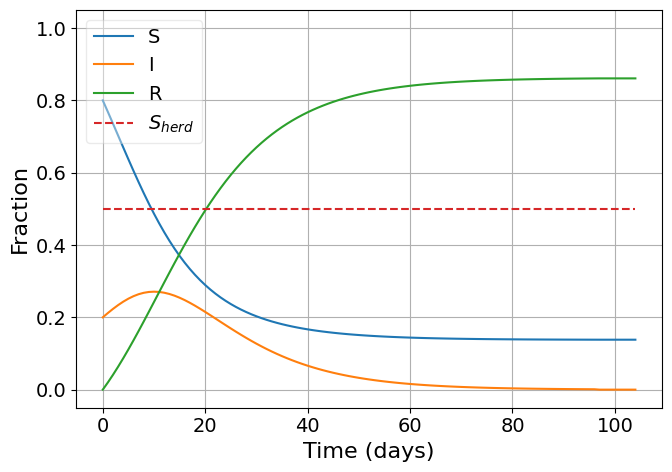

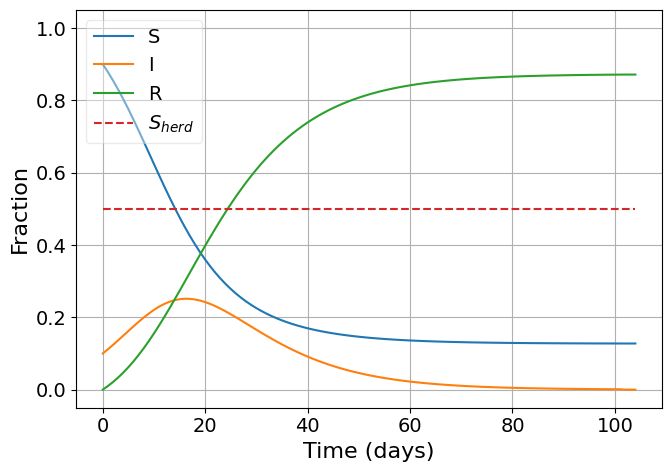

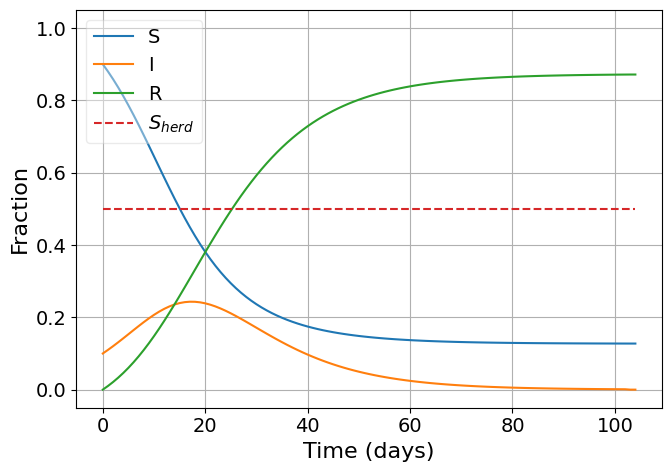

time: 1.08 s (started: 2024-07-15 14:06:42 +00:00)


In [60]:
# No policy, dependent counties
K = np.array([[1,0,0],
             [0.1,1,0],
              [0,0.1,1]])
T = 105
beta = 0.2
gamma = 0.1
S = np.zeros((3,T))
I = np.zeros((3,T))
R = np.zeros((3,T))
pop = 1000
S[0,0] = 0.8*pop
S[1,0] = 0.9*pop
S[2,0] = 0.9*pop
I[0,0] = 0.2*pop
I[1,0] = 0.1*pop
I[2,0] = 0.1*pop
# print(S)
for t in range(1,T):
  S[:,t], I[:,t], R[:,t] = update_network_SIR(S[:,t-1], I[:,t-1], R[:,t-1],
                                              [1,1,1], [pop]*3,
                                              K,
                                              beta=beta, gamma=gamma)

for i in range(3):
  fig, ax= plt.subplots(figsize=(7, 5))
  plt.plot([s/pop for s in S[i]],label='S')
  plt.plot([x/pop for x in I[i]],label='I')
  plt.plot([r/pop for r in R[i]],label='R')
  plt.xlabel('Time (days)')
  ax.grid()
  print('County i')
  print('S:', S[i,:])
  print('I: ', I[i,:])
  print('R: ', R[i,:])
  print(r'$S_{herd}$', gamma/beta)
  ax.set_ylim(-0.05,1.05)
  plt.ylabel('Fraction')
  plt.plot([gamma/beta]*T,'--',label=r'$S_{herd}$')
  plt.legend(ncol=1,loc='best',framealpha=0.4)
  # print(S[idx,-1] + I[idx,-1]+R[idx,-1])
  plt.tight_layout()
  new_path = os.path.join(PATH,'MultiCounty/base_county'+str(i)+'.pdf')
  # print(new_path)
  # plt.savefig(new_path,figsize=(7,5))


In [208]:
# K = np.identity(3)
# alpha = 0.5
# delta_t=10
# T=100
# beta= .2
# gamma = .1
# alpha_level = [0,.5,1]
# county_idx = 0
# S = [90,90,90]
# I = [10,10,10]
# R = [0,0,0]
# county_pop = [100,100,100]
# county_area = [1]*3
# policy_all = [1,1,1]
# best_alpha = update_policy_network(county_idx,policy_all, S,I,R,county_pop, county_area, K, T, delta_t, beta, gamma,alpha_level=alpha_level, alpha_prev=1, kappa = 3/5,eta=2/5, two_sided=False)
# print(best_alpha)

(0, 0.09606091639126554)
time: 15.3 ms (started: 2024-07-14 22:51:31 +00:00)


### dependent counties under a state

In [76]:
T=105
beta= .2
gamma = .1
s0 = {'0': [0.8,0.9,0.9]}
i0 = {'0': [0.2,0.1,0.1]}
K = np.array([[1,0,0],
              [0.1,1,0],
              [0,0.1,1]]
             )
delta_t=7
county_kappa = {'0': [1/3,1/6,1/6,1/6]}
county_eta = {'0': [2/3,1/6,1/6,1/6]}
# S,I,R, policy_all = policy_game_county(beta, gamma, T,
#                         s0,i0,
#                         delta_t=delta_t,
#                         county_pop=[100]*3,
#                         county_area = [1]*3,
#                         kappa_county = [1/100]*3,
#                         eta_county = [99/100]*3,
#                         K = K,
#                         two_sided=True)
res = policy_game_multistate(beta, gamma, T,
                            i0=i0,
                            s0=s0,
                            delta_t=delta_t,
                            county_pop={'0': [100,100,100]},
                            county_area = {'0': [1]*3},
                            # county_kappa = {'0': [1/4,1/100,1/100,1/100]},
                            # county_eta = {'0': [3/4,99/100,99/100,99/100]},
                            # county_kappa = {'0': [1/4,2/3*1/100,2/3*1/100,2/3*1/100]},
                            # county_eta = {'0': [3/4,2/3*99/100,2/3*99/100,2/3*99/100]},
                            county_kappa = county_kappa,
                            county_eta = county_eta,
                            K = K,
                            two_sided=True)

Excitation matrix: [[1.  0.  0. ]
 [0.1 1.  0. ]
 [0.  0.1 1. ]]
time: 375 ms (started: 2024-07-15 14:28:53 +00:00)


In [97]:
print('State policy:', res['0'].policy)
print('County 1 policy:',res['0'].children[0].policy)
print('County 2 policy:',res['0'].children[1].policy)
print('County 3 policy:',res['0'].children[2].policy)


State policy: [(0, 1), (6, 0), (13, 0), (20, 0), (27, 0.5), (34, 0.5), (41, 0.5), (48, 0.5), (55, 0.5), (62, 1), (69, 1), (76, 1), (83, 1), (90, 1), (97, 1), (104, 1)]
County 1 policy: [(0, 1), (6, 0), (13, 0), (20, 0), (27, 0.5), (34, 0.5), (41, 0.5), (48, 0.5), (55, 0.5), (62, 1), (69, 1), (76, 1), (83, 1), (90, 1), (97, 1), (104, 1)]
County 2 policy: [(0, 1), (6, 0), (13, 0), (20, 0), (27, 0.5), (34, 0.5), (41, 0.5), (48, 0.5), (55, 0.5), (62, 1), (69, 1), (76, 1), (83, 1), (90, 1), (97, 1), (104, 1)]
County 3 policy: [(0, 1), (6, 0), (13, 0), (20, 0), (27, 0.5), (34, 0.5), (41, 0.5), (48, 0.5), (55, 0.5), (62, 1), (69, 1), (76, 1), (83, 1), (90, 1), (97, 1), (104, 1)]
time: 5.05 ms (started: 2024-07-15 14:41:41 +00:00)


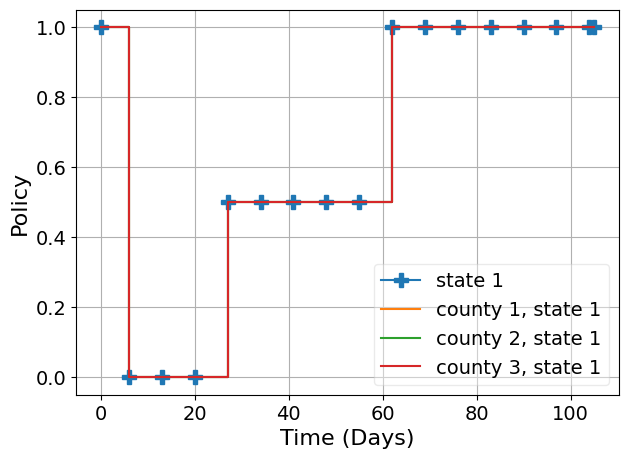

time: 1.55 s (started: 2024-07-15 00:20:56 +00:00)


In [230]:
show_policy_v3(res, T, res['0'].policy,plot_federal=False, figsize=(7,5),ncol=1)

41.16697859377822
28.10860801186372
26.664800987102776
/content/drive/MyDrive/Research/PolicySIR/figure/MultiCounty/state_policy_all.pdf


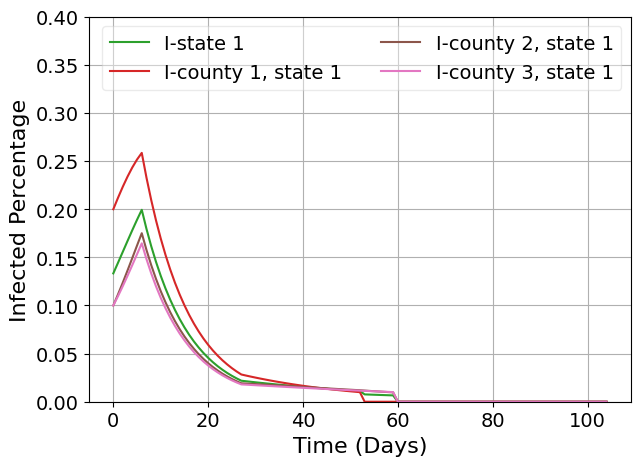

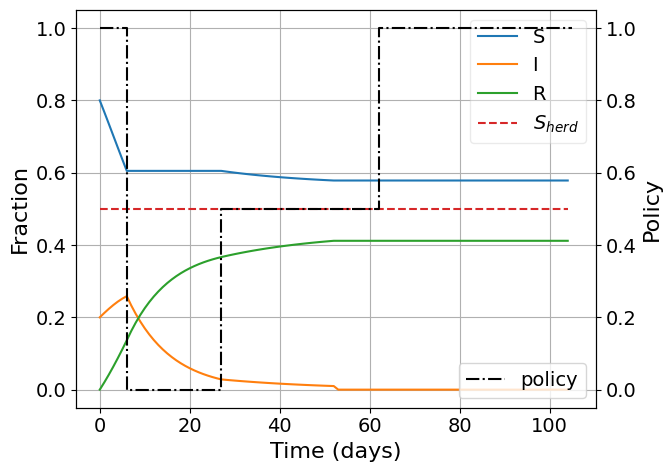

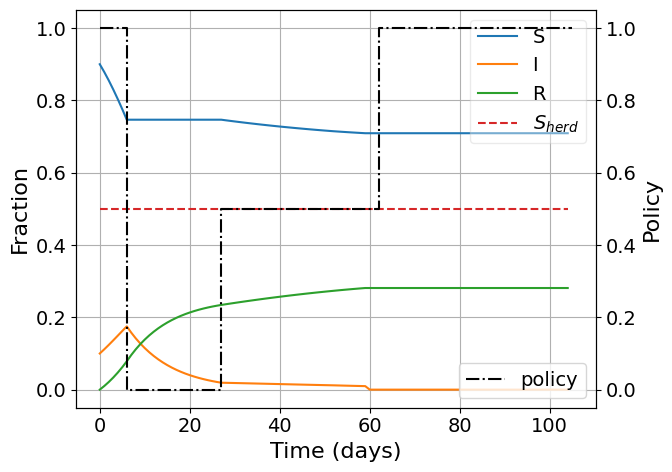

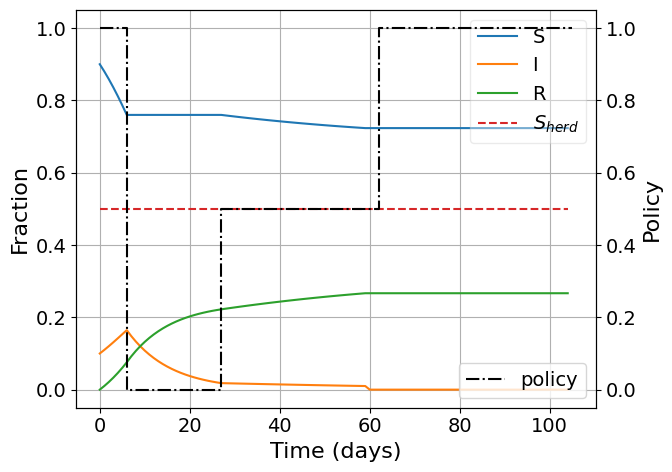

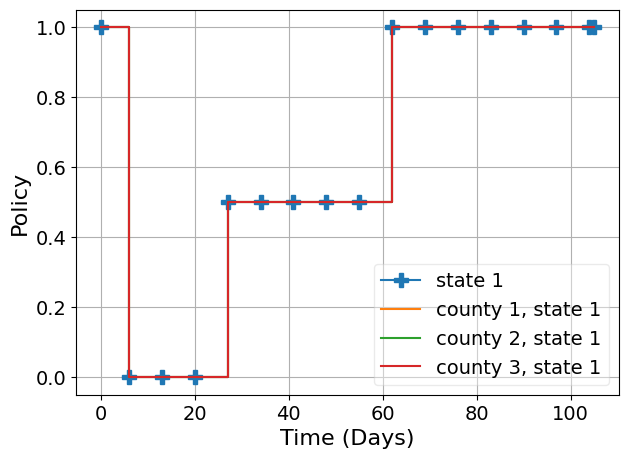

time: 5.99 s (started: 2024-07-15 00:21:10 +00:00)


In [231]:
plot_i_v3(res, T,figsize=(7,5),ncol=2,ylimit=(0,0.4))
for idx,child in enumerate(res['0'].children):
  print(child.R[-1])
  fig, ax= plt.subplots(figsize=(7, 5))
  plt.plot([s/child.population for s in child.S],label='S')
  plt.plot([x/child.population for x in child.I],label='I')
  plt.plot([r/child.population for r in child.R],label='R')
  plt.xlabel('Time (days)')
  ax.set_ylim(-0.05,1.05)
  ax.grid()
  ax.plot([gamma/beta]*T,'--',label=r'$S_{herd}$')
  plt.legend(framealpha=0.4,loc='best')
  ax.set_ylabel('Fraction')
  ax2 = ax.twinx()
  ax2.set_ylim(-0.05,1.05)
  x = [pair[0] for pair in child.policy]+[T]
  policy = [pair[1] for pair in child.policy]+[child.policy[-1][1]]
  ax2.step(x, policy, where='post', label='policy',color='k',linestyle='-.')
  ax2.set_ylabel('Policy')
  ax2.legend(loc='best')
  plt.legend(ncol=1,loc='best')
  plt.tight_layout()
  # new_path = os.path.join(PATH,'MultiCounty/state_county'+str(idx)+'_kappa='+str(round(county_kappa['0'][idx+1],2))+'_eta='+str(round(county_eta['0'][idx+1],2))+'.pdf')
  # print(new_path)
  # plt.savefig(new_path,figsize=(7,5))

# new_path = os.path.join(PATH,'MultiCounty/state_policy_all.pdf')
# print(new_path)
# show_policy_v3(res, T, res['0'].policy,plot_federal=False, save=False,path=new_path,figsize=(7,5),ncol=1)

Excitation matrix: [[1.  0.1]
 [0.1 1. ]]
[(0, 1), (9, 0), (19, 0), (29, 0), (39, 0), (49, 0.5), (59, 0.5), (69, 0.5), (79, 0.5), (89, 0.5), (99, 0.5)]
Excitation matrix: [[1.  0.1]
 [0.1 1. ]]
[(0, 1), (9, 0), (19, 0), (29, 0), (39, 0), (49, 0.5), (59, 0.5), (69, 0.5), (79, 0.5), (89, 0.5), (99, 0.5)]
Excitation matrix: [[1.  0.1]
 [0.1 1. ]]
[(0, 1), (9, 0), (19, 0), (29, 0), (39, 0), (49, 0.5), (59, 0.5), (69, 0.5), (79, 0.5), (89, 0.5), (99, 0.5)]
Excitation matrix: [[1.  0.1]
 [0.1 1. ]]
[(0, 1), (9, 0), (19, 0), (29, 0), (39, 0), (49, 0.5), (59, 0.5), (69, 0.5), (79, 0.5), (89, 0.5), (99, 0.5)]


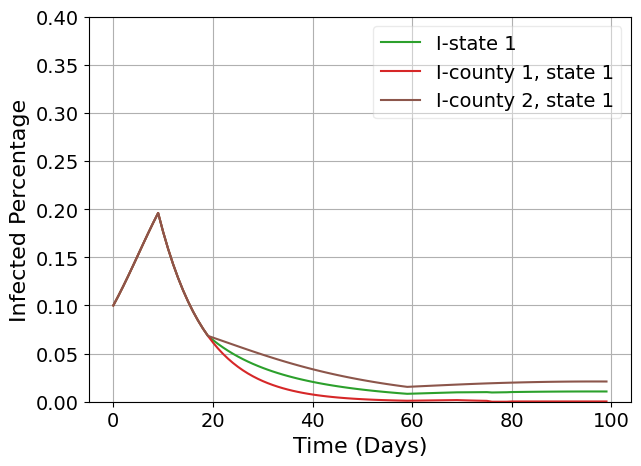

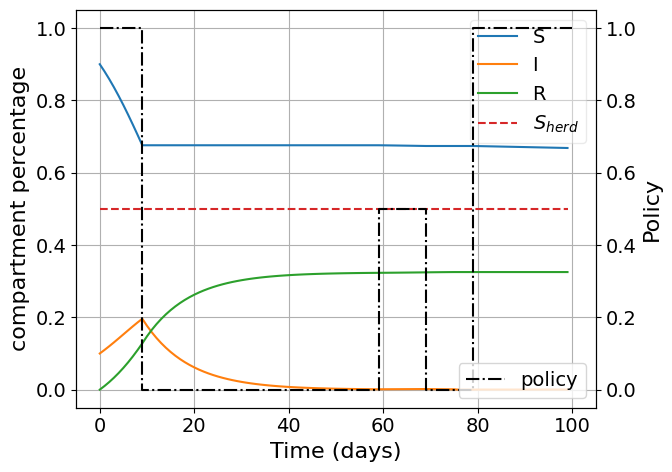

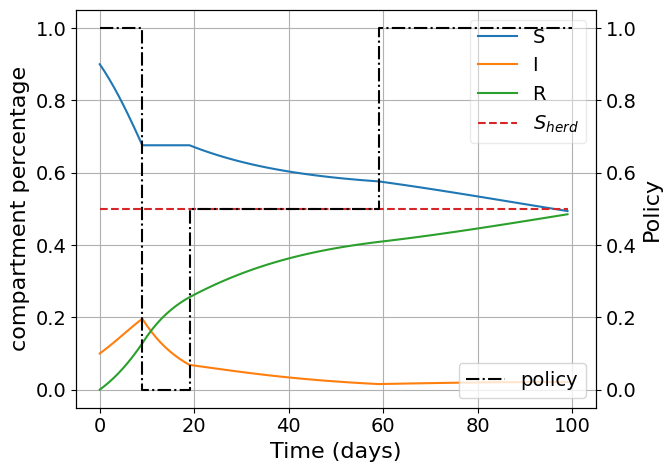

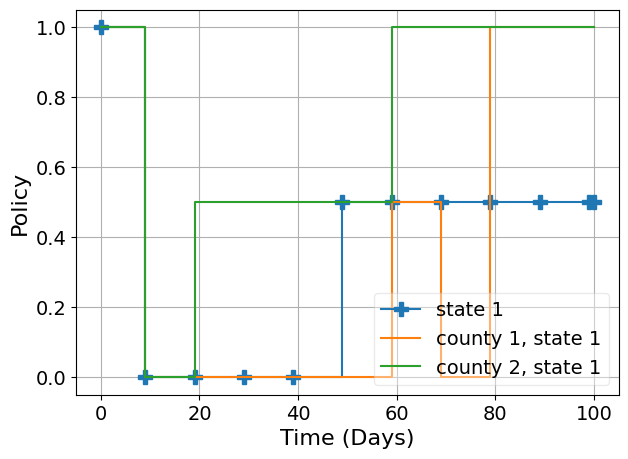

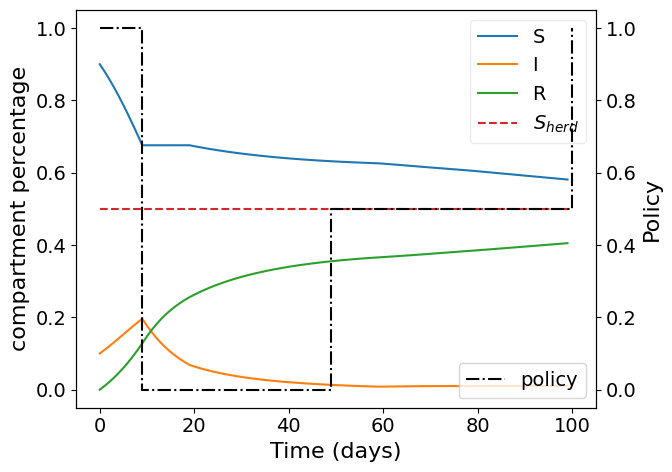

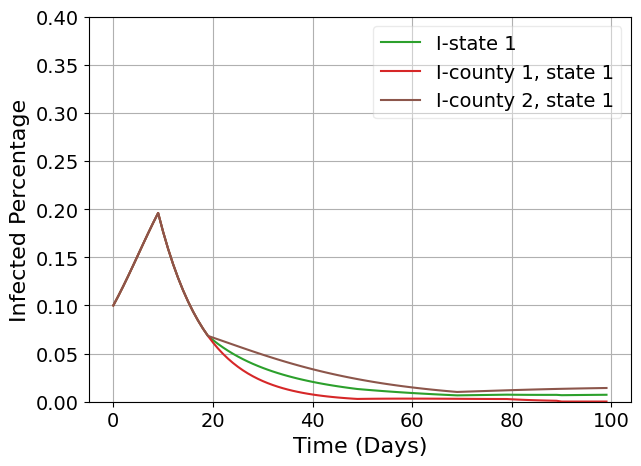

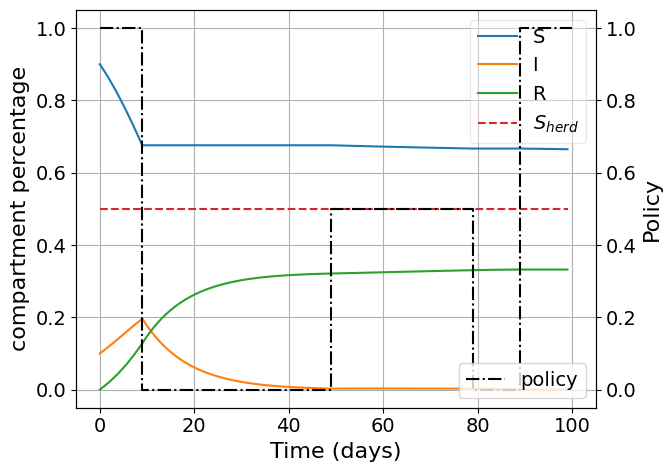

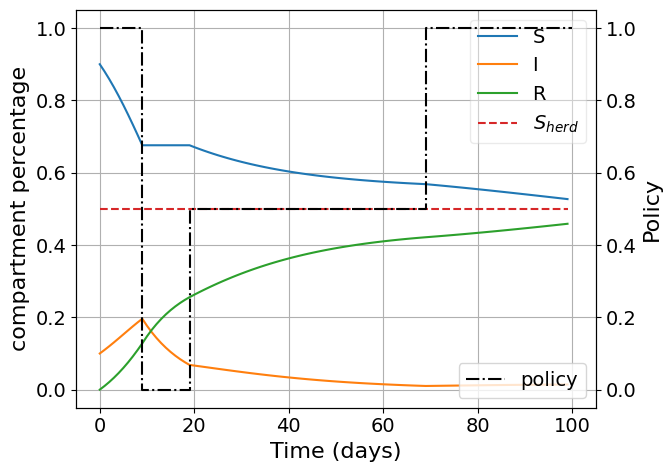

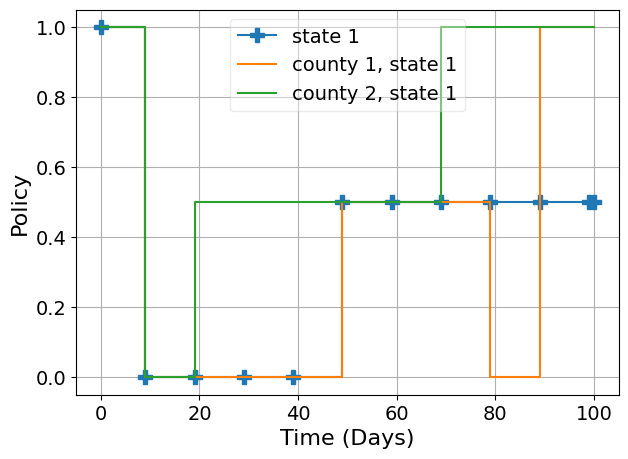

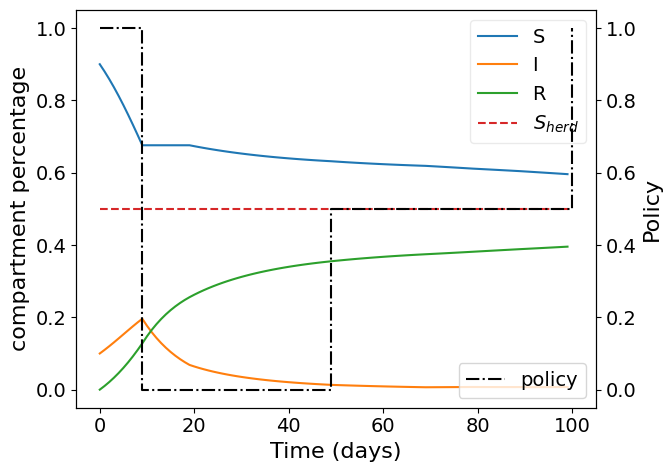

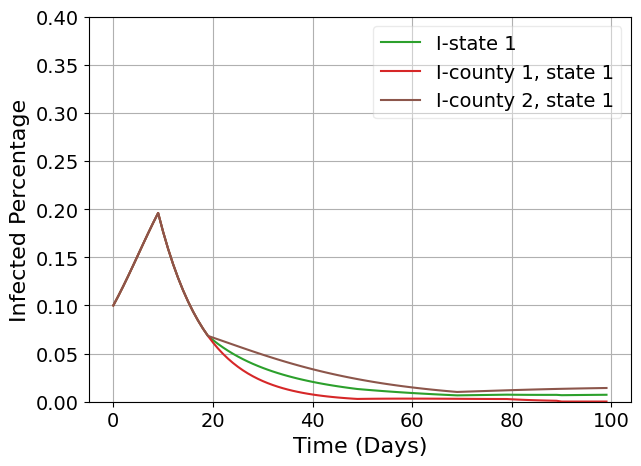

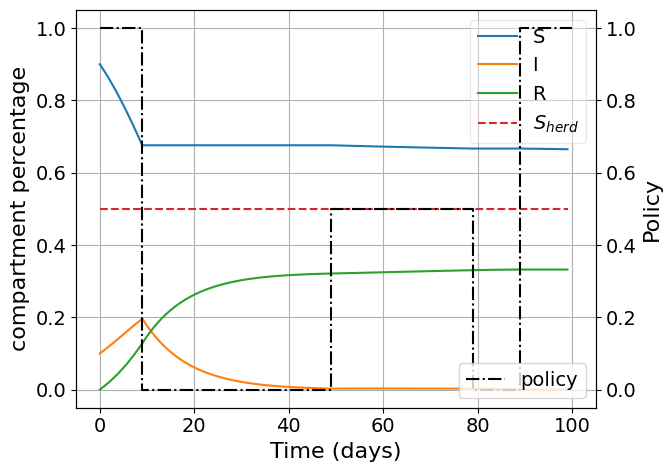

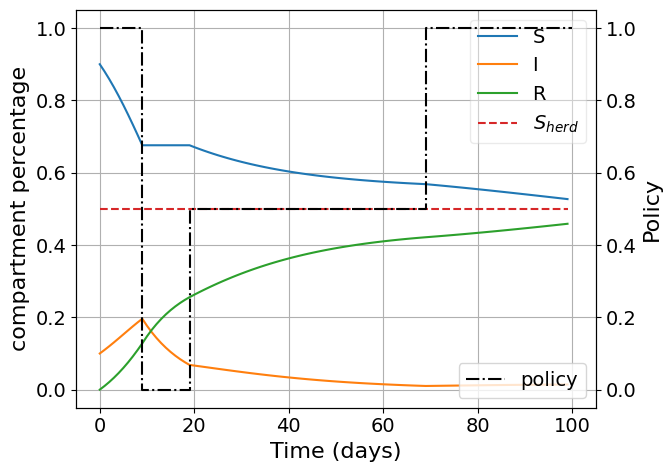

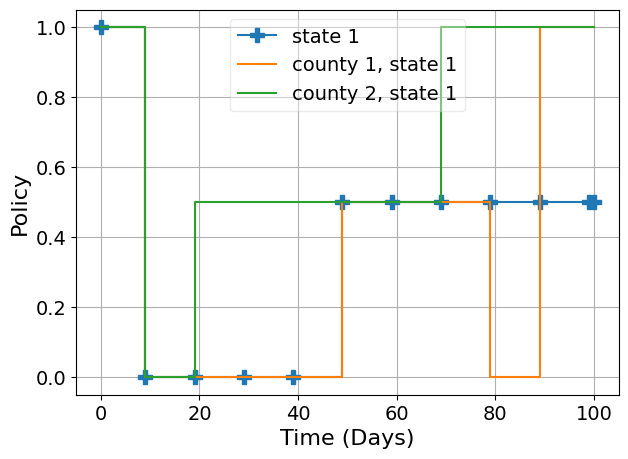

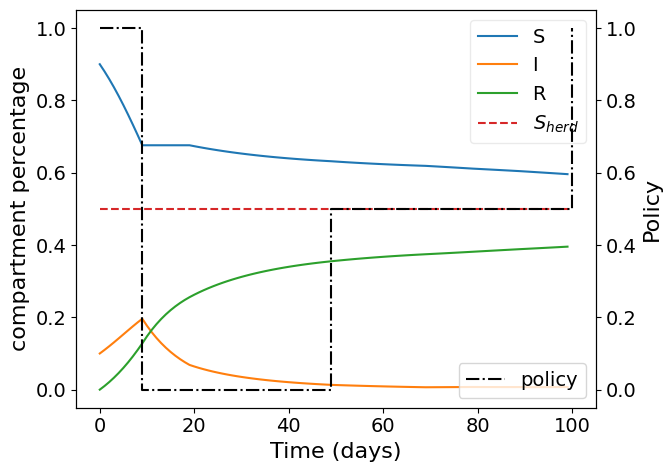

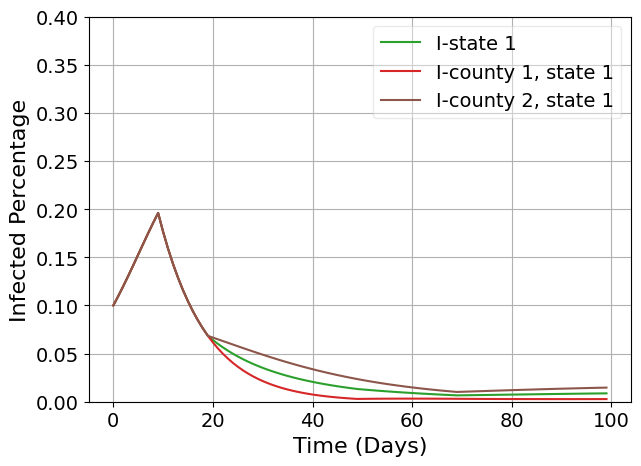

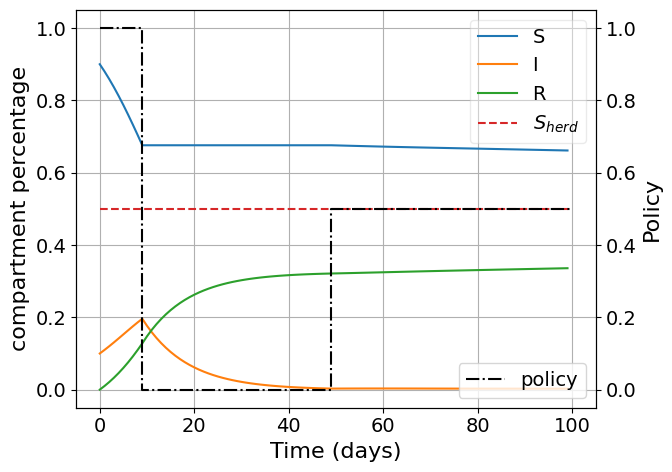

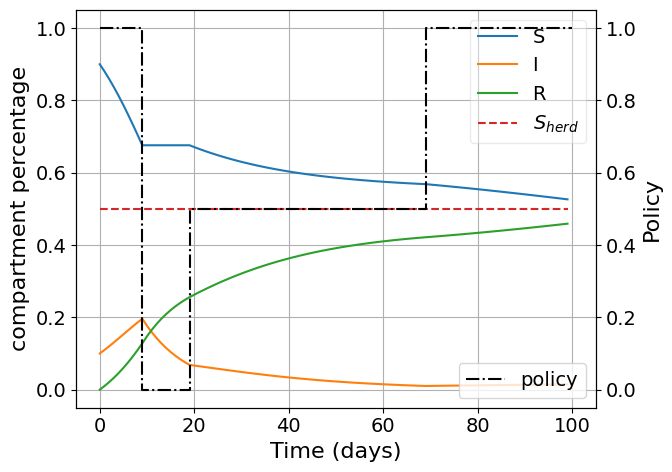

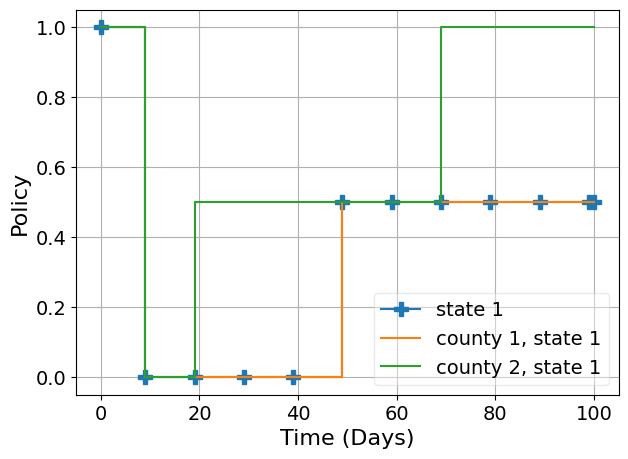

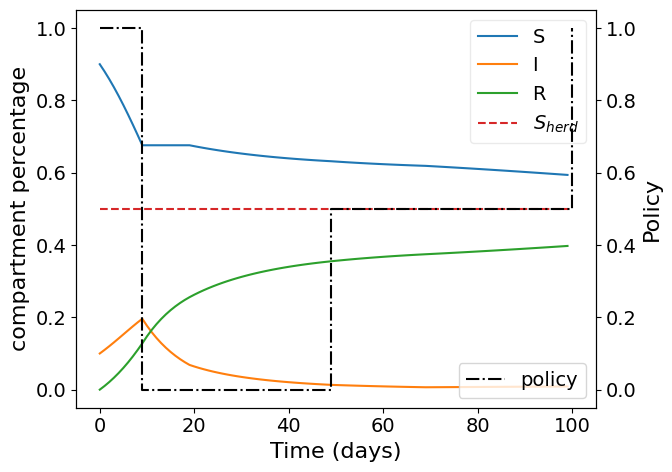

time: 17.2 s (started: 2024-07-14 18:24:29 +00:00)


In [186]:
# Dependent counties
T=100
beta= .2
gamma = .1
K = np.array([[1,0.1],
             [0.1,1]])
for x in [0,1/8, 1/4,1/2]:
  kappa = (1-x)*1/5
  eta = (1 - x)*4/5
  county_kappa = {'0': [1/4,kappa,3/4]}
  county_eta = {'0': [3/4,eta,1/4]}
# county_kappa = {'0': [1/4,1/5*2/3,3/4]}
# county_eta = {'0': [3/4,4/5*2/3,1/4]}

# county_kappa = {'0': [1/4,1/3,1/3,1/3]}
# county_eta = {'0': [3/4,1/3,1/3,1/3]}
  delta_t = 10
  res = policy_game_multistate(beta, gamma, T,
                              i0={'0': [0.1,0.1]},
                              s0={'0': [0.9,0.9]},
                              delta_t = delta_t,
                              county_pop={'0': [1000,1000]},
                              county_area = {'0': [1,1]},
                              county_kappa = county_kappa,
                              county_eta = county_eta,
                              K = K,
                              two_sided=True)
  print(res['0'].policy)

  # for child in res['0'].children:

  #   print(child.policy)
  # print(res['0'].policy)
  plot_i_v3(res, T,figsize=(7,5),ncol=1)
  for child in res['0'].children:
    fig, ax= plt.subplots(figsize=(7, 5))
    ax.grid()
    plt.plot([s/child.population for s in child.S],label='S')
    plt.plot([x/child.population for x in child.I],label='I')
    plt.plot([r/child.population for r in child.R],label='R')
    plt.xlabel('Time (days)')
    ax.set_ylim(-0.05,1.05)
    ax.plot([gamma/beta]*T,'--',label=r'$S_{herd}$')
    plt.legend(framealpha=0.4,loc='best')
    ax.set_ylabel('compartment percentage')
    ax2 = ax.twinx()
    ax2.set_ylim(-0.05,1.05)
    x = [pair[0] for pair in child.policy]+[T]
    policy = [pair[1] for pair in child.policy]+[child.policy[-1][1]]
    ax2.step(x, policy, where='post', label='policy',color='k',linestyle='-.')
    ax2.set_ylabel('Policy')
    ax2.legend(loc='lower right')
    # plt.legend(ncol=1,loc='best')
    # print(S[idx,-1] + I[idx,-1]+R[idx,-1])
    plt.tight_layout()
  show_policy_v3(res, T, res['0'].policy,plot_federal=False, figsize=(7,5),ncol=1)

  fig, ax= plt.subplots(figsize=(7, 5))
  plt.plot([s/res['0'].population for s in res['0'].S],label='S')
  plt.plot([x/res['0'].population for x in res['0'].I],label='I')
  plt.plot([r/res['0'].population for r in res['0'].R],label='R')
  plt.xlabel('Time (days)')
  ax.set_ylim(-0.05,1.05)
  ax.plot([gamma/beta]*T,'--',label=r'$S_{herd}$')
  plt.legend(framealpha=0.4,loc='best')
  ax.set_ylabel('compartment percentage')
  ax2 = ax.twinx()
  ax2.set_ylim(-0.05,1.05)
  x = [pair[0] for pair in res['0'].policy]+[T]
  policy = [pair[1] for pair in res['0'].policy]+[child.policy[-1][1]]
  ax2.step(x, policy, where='post', label='policy',color='k',linestyle='-.')
  ax2.set_ylabel('Policy')
  ax2.legend(loc='lower right')
  # plt.legend(ncol=1,loc='best')
  # print(S[idx,-1] + I[idx,-1]+R[idx,-1])
  plt.tight_layout()

In [110]:
# len(res['0'].children)

time: 347 µs (started: 2024-07-14 17:51:45 +00:00)


In [111]:
# # effecet of pd
# T=100
# beta= .2
# gamma = .1
# pds = [100,1e3,1e4,1e5]
# for pd in pds:
#   res = policy_game_multistate(beta, gamma, T,
#                               i0={'0': [0.1,0.1]},
#                               delta_t=20,
#                               county_pop={'0': [100,100]},
#                               county_area = {'0': [1,100/pd]},
#                               county_kappa = {'0': [1/5,1/3,1/3]},
#                               county_eta = {'0': [4/5,1/3,1/3]},
#                               K = np.identity(2),
#                               two_sided=True)
#   plot_i_v3(res, T,figsize=(7,5),ncol=2)
#   show_policy_v3(res, T, res['0'].policy,plot_federal=False, figsize=(7,5),ncol=2)

time: 497 µs (started: 2024-07-14 17:51:46 +00:00)


In [112]:
# plot_i_v3(res, T,figsize=(7,5),ncol=2)
# show_policy_v3(res, T, res['0'].policy,plot_federal=False, figsize=(7,5),ncol=2)

time: 395 µs (started: 2024-07-14 17:51:46 +00:00)


In [113]:
# print(res['0'].children[0].I[:30])
# print(res['0'].children[1].I[:30])

time: 326 µs (started: 2024-07-14 17:51:46 +00:00)


### Dependent counties with intervention

In [187]:

# three counties without state
# K = np.identity(3)
K= np.array([[1,0,0],
             [0.1,1,0],
             [0,0.1,1]])
alpha = 0.5
delta_t=7
T=105
beta= .2
gamma = .1
alpha_level = [0,.5,1]
county_idx = 0
s0 = [.8,.9,.9]
i0 = [.2,.1,.1]
county_pop = [100]*3
county_area = [1]*3
policy_all = [1,1,1]
kappa_county = [1/2]*3
eta_county = [1/2]*3
S,I,R, policy_all = policy_game_county(beta, gamma, T, s0, i0,
                                      delta_t=delta_t, county_pop=county_pop,
                                      county_area = county_area,
                                      kappa_county = kappa_county,
                                      eta_county = eta_county,
                                      K = K,
                                      alpha_level=alpha_level,
                                      two_sided=True)

Excitation matrix: [[1.  0.  0. ]
 [0.1 1.  0. ]
 [0.  0.1 1. ]]
Updated policy at 1 [0. 0. 0.]
Updated policy at 2 [0. 0. 0.]
Updated policy at 3 [0. 0. 0.]
Updated policy at 4 [0.5 0.5 0.5]
Updated policy at 5 [0.5 0.5 0.5]
Updated policy at 6 [0.5 0.5 0.5]
Updated policy at 7 [0.5 0.5 0.5]
Updated policy at 8 [1.  0.5 0.5]
Updated policy at 9 [1. 1. 1.]
Updated policy at 10 [1. 1. 1.]
Updated policy at 11 [1. 1. 1.]
Updated policy at 12 [1. 1. 1.]
Updated policy at 13 [1. 1. 1.]
Updated policy at 14 [1. 1. 1.]
time: 323 ms (started: 2024-07-14 18:25:23 +00:00)


41.16697859377822
28.10860801186372
26.664800987102776


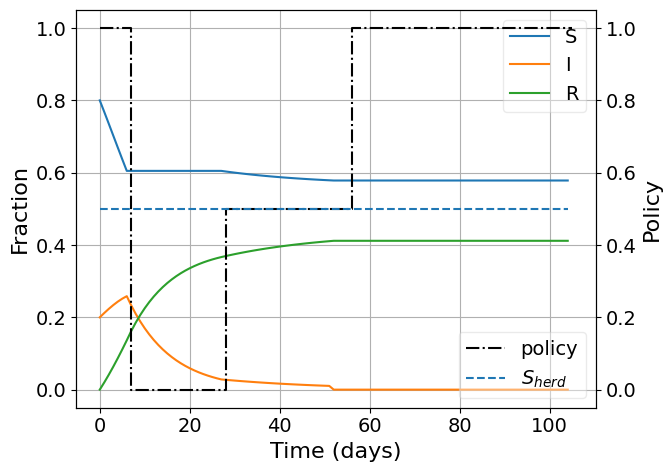

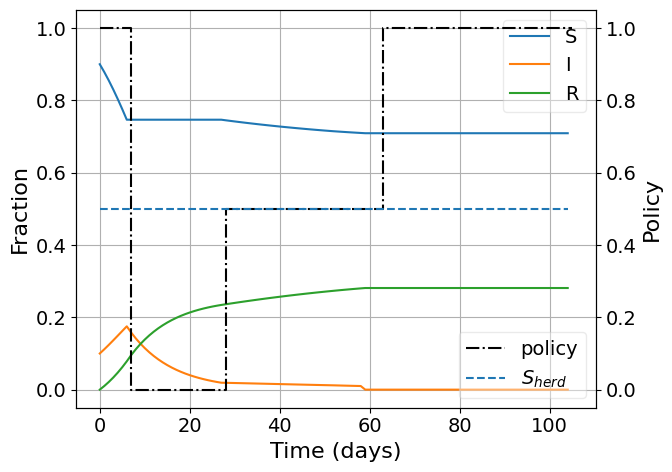

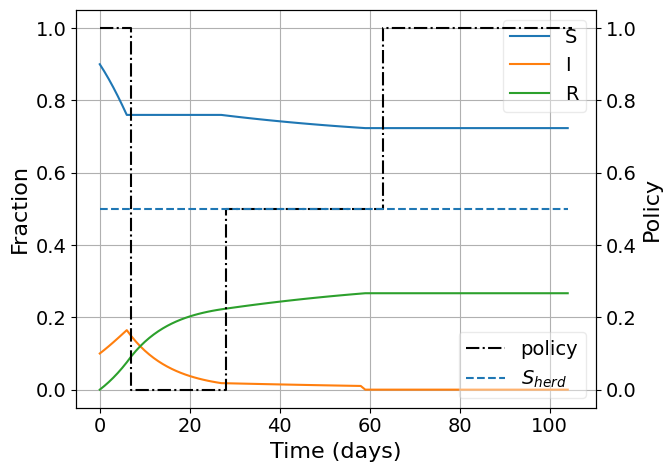

time: 3.41 s (started: 2024-07-14 18:25:31 +00:00)


In [189]:
for idx in range(len(S)):
  fig, ax= plt.subplots(figsize=(7, 5))
  print(R[idx][-1])
  plt.plot([s/county_pop[idx] for s in S[idx]],label='S')
  plt.plot([x/county_pop[idx] for x in I[idx]],label='I')
  plt.plot([r/county_pop[idx] for r in R[idx]],label='R')
  plt.xlabel('Time (days)')
  ax.set_ylim(-0.05,1.05)
  ax.grid()
  plt.legend(framealpha=0.4,loc='best')
  ax.set_ylabel('Fraction')
  ax2 = ax.twinx()
  ax2.set_ylim(-0.05,1.05)
  x = [delta_t*i for i in range(len(policy_all[0]))] + [T]
  y = list(policy_all[idx]) + [policy_all[idx,-1]]
  ax2.step(x,y,where='post', label= 'policy',linestyle='dashdot',color ='k')
  ax2.plot([gamma/beta]*T,'--',label=r'$S_{herd}$')
  ax2.set_ylabel('Policy')
  plt.legend(ncol=1,loc='best',framealpha=0.4)
  # print(S[idx,-1] + I[idx,-1]+R[idx,-1])
  plt.tight_layout()
  new_path = os.path.join(PATH,'MultiCounty/multi_county'+str(idx)+'_kappa='+str(kappa_county[0])+'_eta='+str(eta_county[0])+'.pdf')
  # print(new_path)
  # plt.savefig(new_path,figsize=(7,5))



time: 138 ms (started: 2024-07-14 17:51:47 +00:00)


In [218]:
# # K = 0.01*np.ones((3,3))
# # np.fill_diagonal(K, 1)
# K = np.array([[1,0,0],
#               [0.2,1,0],
#               [0,0.2,1]])
# delta_t=10
# T=100
# beta= .2
# gamma = .1
# alpha_level = [0,.5,1]
# s0 = [.8,.9,.9]
# i0 = [.2,.1,.1]
# county_pop = [100]*3
# county_area = [1]*3
# # kappa_county = [1/10]*3
# # eta_county = [9/10]*3
# kappa_county = [1/2]*3
# eta_county = [1/2]*3
# S,I,R, policy_all = policy_game_county(beta, gamma, T, s0, i0,
#                                       delta_t=delta_t, county_pop=county_pop,
#                                       county_area = county_area,
#                                       kappa_county = kappa_county,
#                                       eta_county = eta_county,
#                                       K = K,
#                                       alpha_level=alpha_level,
#                                       two_sided=True)

Excitation matrix: [[1.  0.  0. ]
 [0.2 1.  0. ]
 [0.  0.2 1. ]]
Updated policy at 1 [0. 0. 0.]
Updated policy at 2 [0. 0. 0.]
Updated policy at 3 [0.5 0.5 0.5]
Updated policy at 4 [0.5 0.5 0.5]
Updated policy at 5 [1.  0.5 0.5]
Updated policy at 6 [1.  0.5 0.5]
Updated policy at 7 [1. 1. 1.]
Updated policy at 8 [1. 1. 1.]
Updated policy at 9 [1. 1. 1.]
time: 208 ms (started: 2024-07-15 00:11:08 +00:00)


[[3.6496498  3.28468482 3.12517166 2.97287688 2.82752736 2.68885463
  2.55659553 2.43049269 2.31029491 2.19575759 2.08664288 1.98271997
  1.88376514 1.78956193 1.69990109 1.61458066 1.53340588]
 [3.28754699 2.95879229 2.88280218 2.8070783  2.73176965 2.657012
  2.58292856 2.50963061 2.43721817 2.3657806  2.29539725 2.2261381
  2.15806429 2.09122875 2.02567674 1.96144637 1.89856914]
 [3.00733882 2.70660494 2.64701144 2.58791089 2.5293375  2.4713243
  2.41390302 2.35710395 2.30095586 2.24548592 2.19071961 2.13668072
  2.0833913  2.03087162 1.97914021 1.92821384 1.87810752]]


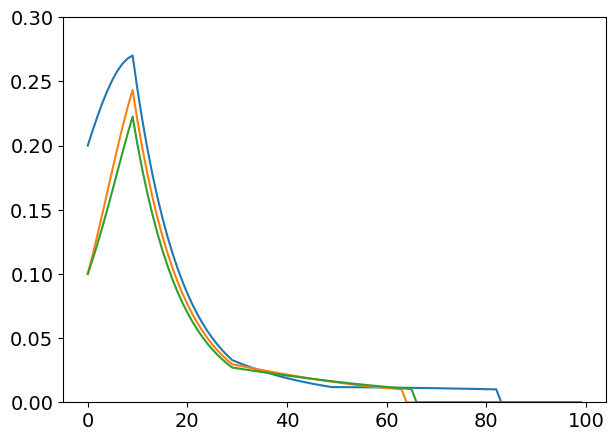

time: 232 ms (started: 2024-07-15 00:12:18 +00:00)


In [220]:
# fig, ax= plt.subplots(figsize=(7, 5))
# for idx in range(len(S)):
#   # plt.plot([s/county_pop[idx] for s in S[idx]],label='S')
#   plt.plot([x/county_pop[idx] for x in I[idx]],label='I')
#   # plt.plot([r/county_pop[idx] for r in R[idx]],label='R')
#   ax.set_ylim(0,0.3)

# print(I[:,28:45])

99.00332661555123
98.62762482359173
99.02468082806277


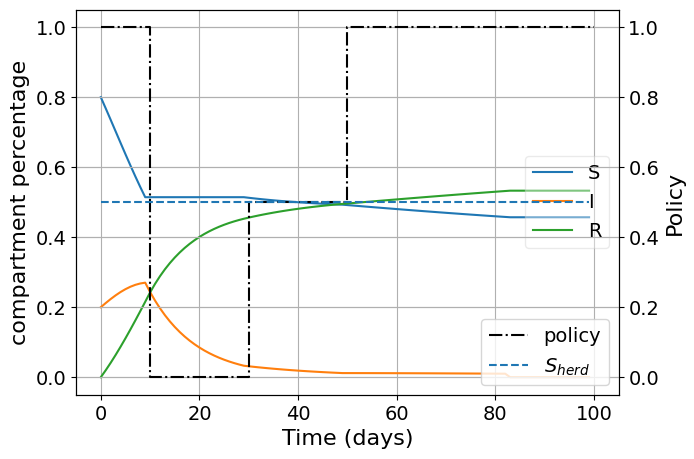

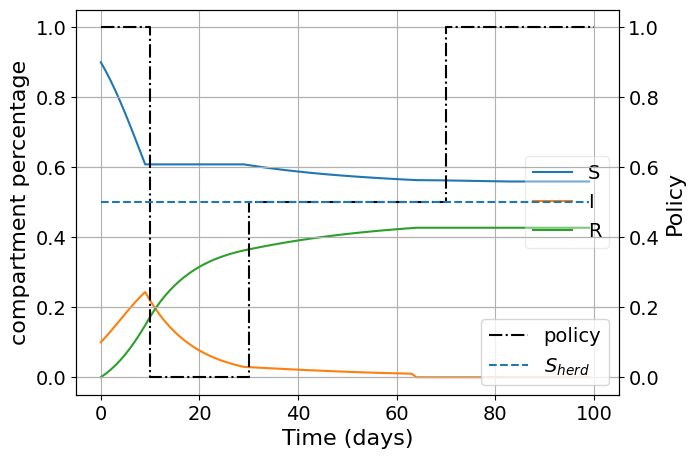

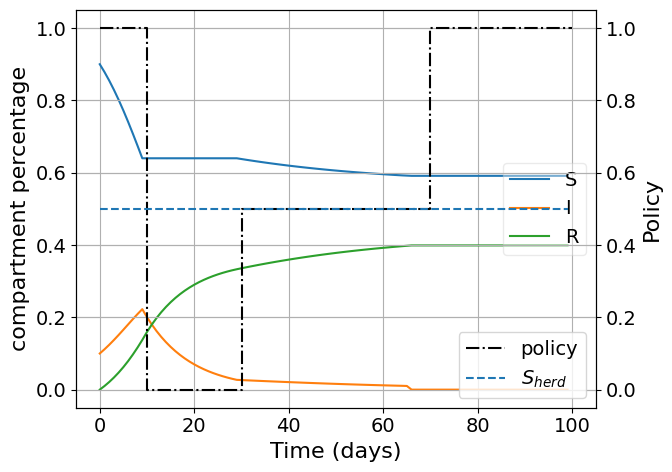

time: 1.49 s (started: 2024-07-15 00:12:19 +00:00)


In [221]:
# for idx in range(len(S)):
#   fig, ax= plt.subplots(figsize=(7, 5))
#   plt.plot([s/county_pop[idx] for s in S[idx]],label='S')
#   plt.plot([x/county_pop[idx] for x in I[idx]],label='I')
#   plt.plot([r/county_pop[idx] for r in R[idx]],label='R')
#   ax.set_ylim(-0.05,1.05)
#   ax.grid()
#   plt.xlabel('Time (days)')
#   plt.legend(framealpha=0.4,loc='right')
#   ax.set_ylabel('compartment percentage')
#   ax2 = ax.twinx()
#   ax2.set_ylim(-0.05,1.05)
#   x = [delta_t*i for i in range(len(policy_all[0]))] + [T]
#   y = list(policy_all[idx]) + [policy_all[idx,-1]]
#   ax2.step(x,y,where='post', label= 'policy',linestyle='dashdot',color ='k')
#   ax2.plot([gamma/beta]*T,'--',label=r'$S_{herd}$')
#   ax2.set_ylabel('Policy')
#   ax2.grid()
#   plt.legend(ncol=1,loc='best')
#   print(S[idx,-1] + I[idx,-1]+R[idx,-1])

# plt.tight_layout()

## Policy intensity $\alpha$ vs cost

/content/drive/MyDrive/Research/PolicySIR/figure/SingleCounty/cost_vs_alpha.eps


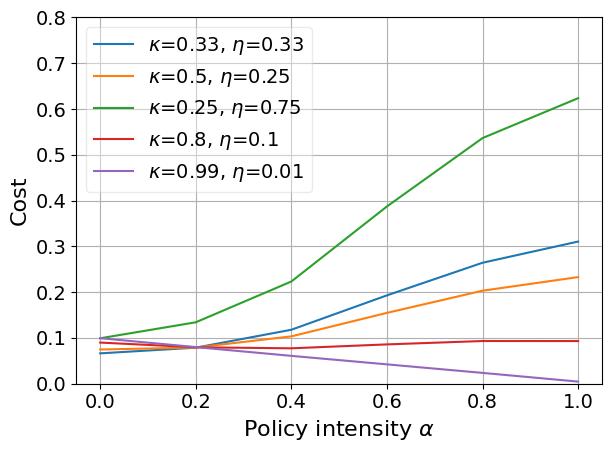

time: 2.25 s (started: 2024-07-14 17:51:55 +00:00)


In [126]:
# K = np.array([[1,0.1],
#               [0.1,1]]
#              )
K = np.array([[1,0],
              [0,1]]
             )
delta_t=10
T=100
beta= .2
gamma = .1
alpha_level = [0,.5,1]
s0 = np.array([.9,.9])
i0 = np.array([.1,.1])
r0 = np.array([.0,.0])
# kappa_county = [1/10]*3
# eta_county = [9/10]*3
kappa = 1/3
eta = 1/3
alpha_level = [0,0.2,0.4,0.6,0.8,1]
cost_all = []
N=[1000]*2
A=[1]*2
policy_all = [1,1]
cost_all = []
for alpha in alpha_level:
  cost_all.append(cost_network(alpha, county_idx,
                               policy_all, s0*N, i0*N, r0*N,
                               N, A, K, T,
                               delta_t,beta,
                               gamma,alpha_prev=0,
                               kappa = kappa,eta=eta,
                               two_sided=True))
plt.plot(alpha_level,cost_all,label = r'$\kappa$='+str(round(kappa,2))+', $\eta$='+str(round(eta,2)))

kappa = 1/2
eta = 1/4
cost_all = []
for alpha in alpha_level:
  cost_all.append(cost_network(alpha, county_idx,
                               policy_all, s0*N, i0*N, r0*N,
                               N, A, K, T,
                               delta_t,beta,
                               gamma,alpha_prev=0,
                               kappa = kappa,eta=eta,
                               two_sided=True))
plt.plot(alpha_level,cost_all,label = r'$\kappa$='+str(round(kappa,2))+', $\eta$='+str(round(eta,2)))

kappa = 1/4
eta = 3/4
cost_all = []
for alpha in alpha_level:
  cost_all.append(cost_network(alpha, county_idx,
                               policy_all, s0*N, i0*N, r0*N,
                               N, A, K, T,
                               delta_t,beta,
                               gamma,alpha_prev=0,
                               kappa = kappa,eta=eta,
                               two_sided=True))
plt.plot(alpha_level,cost_all,label = r'$\kappa$='+str(round(kappa,2))+', $\eta$='+str(round(eta,2)))

kappa = 4/5
eta = 1/10
cost_all = []
for alpha in alpha_level:
  cost_all.append(cost_network(alpha, county_idx,
                               policy_all, s0*N, i0*N, r0*N,
                               N, A, K, T,
                               delta_t,beta,
                               gamma,alpha_prev=0,
                               kappa = kappa,eta=eta,
                               two_sided=True))
plt.plot(alpha_level,cost_all,label = r'$\kappa$='+str(round(kappa,2))+', $\eta$='+str(round(eta,2)))

kappa = 99/100
eta = 1/200
cost_all = []
for alpha in alpha_level:
  cost_all.append(cost_network(alpha, county_idx,
                               policy_all, s0*N, i0*N, r0*N,
                               N, A, K, T,
                               delta_t,beta,
                               gamma,alpha_prev=0,
                               kappa = kappa,eta=eta,
                               two_sided=True))
plt.plot(alpha_level,cost_all,label = r'$\kappa$='+str(round(kappa,2))+', $\eta$='+str(round(eta,2)))

plt.ylim(0,0.8)
plt.legend(framealpha=0.4)
plt.xlabel(r'Policy intensity $\alpha$')
plt.ylabel('Cost')
# plt.title('cost vs alpha')
plt.tight_layout()
plt.grid()
new_path = os.path.join(PATH,"SingleCounty/cost_vs_alpha.eps")
print(new_path)
plt.savefig(new_path)
# ax.set_ylim((0,0.008))

plt.show()

In [127]:
# K = np.array([[1,0.1],
#               [0.1,1]]
#              )
# delta_t=10
# T=100
# beta= .2
# gamma = .1
# alpha_level = [0,.5,1]
# s0 = np.array([.6,.6])
# i0 = np.array([.1,.1])
# r0 = np.array([.0,.0])
# # kappa_county = [1/10]*3
# # eta_county = [9/10]*3
# kappa = 1/3
# eta = 1/3
# alpha_level = [0,0.2,0.4,0.6,0.8,1]
# cost_all = []
# N=[1000]*2
# A=[1]*2
# policy_all = [1,1]
# cost_all = []
# for alpha in alpha_level:
#   cost_all.append(cost_network(alpha, county_idx,
#                                policy_all, s0*N, i0*N, r0*N,
#                                N, A, K, T,
#                                delta_t,beta,
#                                gamma,alpha_prev=0,
#                                kappa = kappa,eta=eta,
#                                two_sided=True))
# plt.plot(alpha_level,cost_all,label = r'$\kappa$='+str(round(kappa,2))+',$\eta$='+str(round(eta,2)))
# plt.xlabel('alpha')
# plt.ylabel('cost')

# kappa = 1/2
# eta = 1/4
# cost_all = []
# for alpha in alpha_level:
#   cost_all.append(cost_network(alpha, county_idx,
#                                policy_all, s0*N, i0*N, r0*N,
#                                N, A, K, T,
#                                delta_t,beta,
#                                gamma,alpha_prev=0,
#                                kappa = kappa,eta=eta,
#                                two_sided=True))
# plt.plot(alpha_level,cost_all,label = r'$\kappa$='+str(round(kappa,2))+',$\eta$='+str(round(eta,2)))

# kappa = 1/4
# eta = 3/4
# cost_all = []
# for alpha in alpha_level:
#   cost_all.append(cost_network(alpha, county_idx,
#                                policy_all, s0*N, i0*N, r0*N,
#                                N, A, K, T,
#                                delta_t,beta,
#                                gamma,alpha_prev=0,
#                                kappa = kappa,eta=eta,
#                                two_sided=True))
# plt.plot(alpha_level,cost_all,label = r'$\kappa$='+str(round(kappa,2))+',$\eta$='+str(round(eta,2)))

# kappa = 4/5
# eta = 1/10
# cost_all = []
# for alpha in alpha_level:
#   cost_all.append(cost_network(alpha, county_idx,
#                                policy_all, s0*N, i0*N, r0*N,
#                                N, A, K, T,
#                                delta_t,beta,
#                                gamma,alpha_prev=0,
#                                kappa = kappa,eta=eta,
#                                two_sided=True))
# plt.plot(alpha_level,cost_all,label = r'$\kappa$='+str(round(kappa,2))+',$\eta$='+str(round(eta,2)))

# kappa = 99/100
# eta = 1/200
# cost_all = []
# for alpha in alpha_level:
#   cost_all.append(cost_network(alpha, county_idx,
#                                policy_all, s0*N, i0*N, r0*N,
#                                N, A, K, T,
#                                delta_t,beta,
#                                gamma,alpha_prev=0,
#                                kappa = kappa,eta=eta,
#                                two_sided=True))
# plt.plot(alpha_level,cost_all,label = r'$\kappa$='+str(round(kappa,2))+',$\eta$='+str(round(eta,2)))

# plt.ylim(0,0.8)
# plt.legend(framealpha=0.4)


time: 3.94 ms (started: 2024-07-14 17:51:58 +00:00)


In [128]:
#               [0.1,1]]
#              )
# delta_t=10
# T=100
# beta= .2
# gamma = .1
# alpha_level = [0,.5,1]
# s0 = np.array([.9,.9])
# i0 = np.array([.1,.1])
# r0 = np.array([.0,.0])
# # kappa_county = [1/10]*3
# # eta_county = [9/10]*3
# kappa = 1/2
# eta_county = 1/4
# alpha_level = [0,0.2,0.4,0.6,0.8,1]
# cost_all = []
# N=[1000]*2
# A=[1]*2
# policy_all = [1,1]
# for alpha in alpha_level:
#   cost_all.append(cost_network(alpha, county_idx,
#                                policy_all, s0*N, i0*N, r0*N,
#                                N, A, K, T,
#                                delta_t,beta,
#                                gamma,alpha_prev=0,
#                                kappa = kappa,eta=eta,
#                                two_sided=True))
# plt.plot(alpha_level,cost_all)
# plt.xlabel('alpha')
# plt.ylabel('cost')

time: 579 µs (started: 2024-07-14 17:51:58 +00:00)


## Compareing with Bliman (Fig 2)

### Figure 2a

 start_grid: 7
start date: 49.0
end_grid: 14
end date: 98.0
Optimal policy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Min cost: 0.6967959299680522
implementation cost: 0
impact cost: 0.6967959299680522
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


<Figure size 640x480 with 0 Axes>

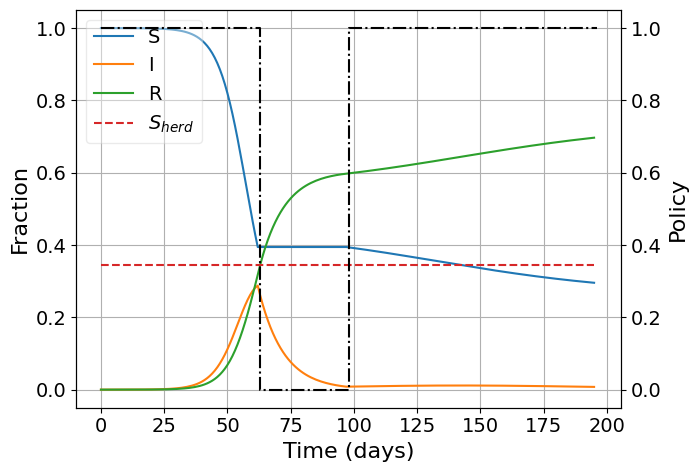

Final size: 0.29559703094666834
time: 7.16 s (started: 2024-07-14 17:53:35 +00:00)


In [132]:
#bliman single search
# figure
T = 196 #200
beta =0.29
gamma=0.1
plt.figure()
county_pop=6.7e4
# I0 = 1.49e-3
# for i,delta_t in enumerate([7,14,21,28]):
I_all = []
optimal_policy_all = []
delta_t =7
# kappa=1/50,eta=49/50
kappa = 0
eta = 1
start_ratio = delta_t*7/T
%prun
for end_ratio in [0.5]:
  optimal_policy,cost_min, S,I,R,_,_,_ = single_county_search(T=T,
                                                        delta_t=delta_t,
                                                        S0 = county_pop - 1,
                                                        I0 = 1,
                                                        start_ratio = start_ratio,
                                                        end_ratio = end_ratio,
                                                        county_pop = county_pop,
                                                        county_area = 1,
                                                        kappa=kappa,eta=eta,
                                                        beta =beta,gamma=gamma,
                                                        reach_hi=True, modification=True,
                                                        verbose=False,to_infinity=False)

  x = [delta_t*i for i in range(len(optimal_policy))] + [T]
  y = list(optimal_policy) + [optimal_policy[-1]]
  print(optimal_policy)
  I_all.append(I)
  optimal_policy_all.append(optimal_policy)
  fig,ax = plt.subplots(figsize=(7, 5))
  ax.plot(S/67000,label='S')
  ax.plot(I/67000,label='I')
  ax.plot(R/67000,label='R')
  ax.set_ylim(-0.05,1.05)

  ax.plot([gamma/beta]*T,'--',label=r'$S_{herd}$')
  plt.legend(ncol=1,loc='upper left',framealpha=0.4)
  plt.xlabel('Time (days)')
  plt.grid()
  ax.set_ylabel('Fraction')

  ax2 = ax.twinx()
  ax2.step(x,y,label= 'policy',linestyle='dashdot',where='post',color ='k')
  ax2.set_ylim(-0.05,1.05)
  plt.tight_layout()
  ax2.set_ylabel('Policy')
  # plt.title('End ratio = '+str(end_ratio))
  # new_path = os.path.join(PATH,'SingleCounty/optimal_policy_delta_t='+str(delta_t)+'.pdf')
  # print(new_path)
  # plt.savefig(new_path)
  plt.show()

  print('Final size:',S[-1]/67000)


### Figure 2c

start_grid: 1
start date: 28.0
end_grid: 4
end date: 98.0
Optimal policy: [1.0, 1.0, 0.5, 0.0, 1.0, 1.0, 1.0]
Min cost: 0.67557814441742
implementation cost: 0
impact cost: 0.67557814441742
[1.0, 1.0, 0.5, 0.0, 1.0, 1.0, 1.0]


<Figure size 640x480 with 0 Axes>

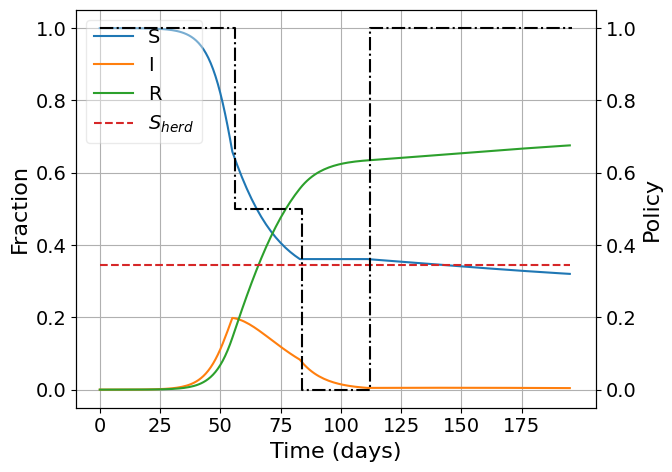

Final size: 0.32015554003276026
time: 882 ms (started: 2024-07-14 17:54:37 +00:00)


In [134]:
#bliman single search

import matplotlib.ticker as ticker
T = 196 #200
beta =0.29
gamma=0.1
plt.figure()
county_pop=6.7e4
# I0 = 1.49e-3
# for i,delta_t in enumerate([7,14,21,28]):
I_all = []
optimal_policy_all = []
delta_t =28
# kappa=1/50,eta=49/50
kappa = 0
eta = 1
start_ratio = delta_t/T

for end_ratio in [0.5]:
  optimal_policy,cost_min, S,I,R,_,_,_ = single_county_search(T=T,
                                                        delta_t=delta_t,
                                                        S0 = county_pop - 1,
                                                        I0 = 1,
                                                        start_ratio = start_ratio,
                                                        end_ratio = end_ratio,
                                                        county_pop = county_pop,
                                                        county_area = 1,
                                                        kappa=kappa,eta=eta,
                                                        beta =beta,gamma=gamma,
                                                        reach_hi=True, modification=True,
                                                        verbose=False,to_infinity=False)

  x = [delta_t*i for i in range(len(optimal_policy))] + [T]
  y = list(optimal_policy) + [optimal_policy[-1]]
  print(optimal_policy)
  I_all.append(I)
  optimal_policy_all.append(optimal_policy)
  fig,ax = plt.subplots(figsize=(7, 5))


  ax.plot(S/67000,label='S')
  ax.plot(I/67000,label='I')
  ax.plot(R/67000,label='R')
  ax.set_ylim(-0.05,1.05)

  ax.plot([gamma/beta]*T,'--',label=r'$S_{herd}$')
  plt.legend(ncol=1,loc='upper left',framealpha=0.4)
  ax.set_xticks(np.arange(0, 200, 25))
  plt.xlabel('Time (days)')
  plt.grid()
  ax.set_ylabel('Fraction')
  # ax.xaxis.set_minor_locator(ticker.FixedLocator([0,25,50,75,100,125,150,175,200]))
  # ax.xaxis.set_minor_locator(ticker.MaxNLocator(8))

  ax2 = ax.twinx()
  ax2.step(x,y,label= 'policy',linestyle='dashdot',where='post',color ='k')
  ax2.set_ylim(-0.05,1.05)
  plt.tight_layout()
  ax2.set_ylabel('Policy')
  plt.tight_layout()

  # plt.title('End ratio = '+str(end_ratio))
  # new_path = os.path.join(PATH,'SingleCounty/optimal_policy_delta_t='+str(delta_t)+'.pdf')
  # # print(new_path)
  # plt.savefig(new_path)
  plt.show()

  print('Final size:',S[-1]/67000)


[1.0, 1.0, 0.5, 0.0, 1.0, 1.0, 1.0]


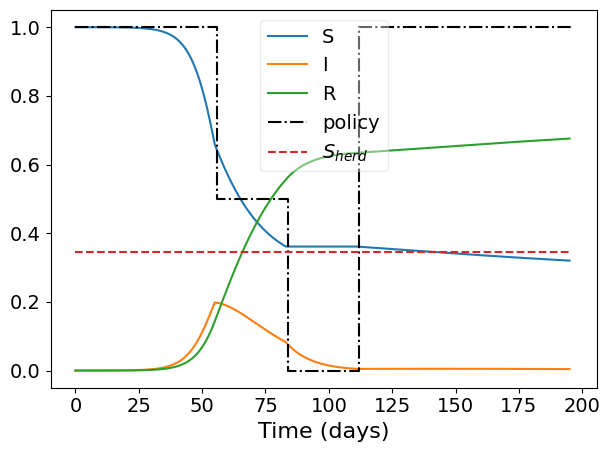

time: 826 ms (started: 2024-07-14 17:54:44 +00:00)


In [135]:
  # x = [delta_t*i for i in range(len(optimal_policy))] + [T]
  # y = list(optimal_policy) + [optimal_policy[-1]]
  # print(optimal_policy)
  # I_all.append(I)
  # optimal_policy_all.append(optimal_policy)
  # plt.figure()
  # plt.plot(S/67000,label='S')
  # plt.plot(I/67000,label='I')
  # plt.plot(R/67000,label='R')
  # plt.step(x,y,label= 'policy',linestyle='dashdot',where='post',color ='k')
  # plt.plot([gamma/beta]*T,'--',label=r'$S_{herd}$')
  # plt.legend(ncol=1,loc='best',framealpha=0.4)
  # plt.xlabel('Time (days)')
  # plt.tight_layout()
  # # plt.title('End ratio = '+str(end_ratio))
  # # new_path = os.path.join(PATH,"SingleCounty/optimal_policy_delta_t=5.pdf")
  # # print(new_path)
  # # plt.savefig(new_path,figsize=(7,5))
  # # plt.show()

### Figure 2d

Final size: 0.17413958350267603


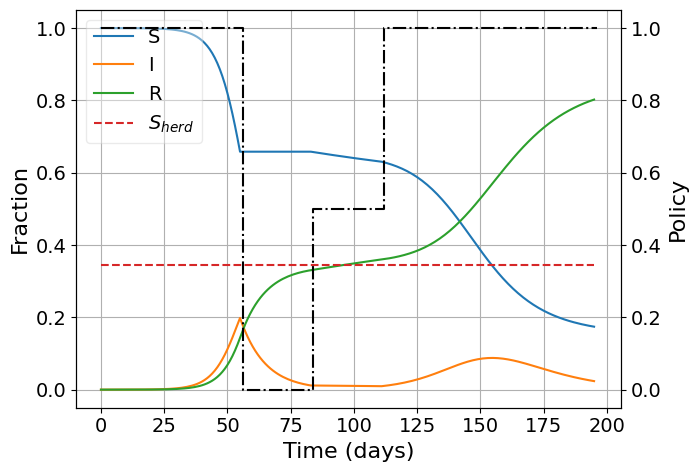

time: 1.19 s (started: 2024-07-14 17:55:09 +00:00)


In [137]:
# start policy compelete lockdown at day 60
S0 = 67000 - 1
I0 = 1
county_pop = 67000
county_area = 1
beta=0.29
gamma=0.1
T= 196
# delta_t = 20
# policy = [1.0, 1.0, 1.0, 0.5, 0, 1.0, 1.0, 1.0, 1.0, 1.0]
# policy = [1.0, 1.0, 1.0, 0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0]
# delta_t = 10
# policy = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0,
#           0.0, 0.0, 0.0, 0.0,
#           1.0, 1.0, 1.0, 1.0, 1.0,1.0,1.0,1.0,1.0,1.0]
# delta_t = 5
# policy = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,
#           1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
#           1.0, 1.0, 1.0, 1.0, 1.0,1.0,1.0,1.0,1.0,1.0,
#           1.0, 1.0, 1.0, 1.0, 1.0,1.0,1.0,1.0,1.0,1.0]
# policy = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,
#           1.0, 1.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
#           1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,
#           1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
delta_t =28
# policy = [1.0, 1.0, 0.5, 0.0, 1.0, 1.0, 1.0]
policy = [1.0, 1.0, 0, 0.5, 1.0, 1.0, 1.0]
cost_min,S,I,R,_,_ = evaluate_cost_single(S0, I0, county_pop, county_area,
                                      policy,delta_t,T=T,
                                      beta =beta,gamma=gamma,
                                      kappa = 0, eta = 1)
fig,ax = plt.subplots(figsize=(7,5))
ax.plot(S/67000,label='S')
ax.plot(I/67000,label='I')
ax.plot(R/67000,label='R')
x = [delta_t*i for i in range(len(policy))] + [T]
ax.set_ylim(-0.05,1.05)

ax.plot([gamma/beta]*T,'--',label=r'$S_{herd}$')
plt.legend(ncol=1,loc='upper left',framealpha=0.4)
plt.xlabel('Time (days)')
plt.grid()
ax.set_ylabel('Fraction')

ax2 = ax.twinx()
ax2.step(x,policy+[policy[-1]],label= 'policy',linestyle='dashdot',where='post',color ='k')
ax2.set_ylim(-0.05,1.05)
plt.tight_layout()
ax2.set_ylabel('Policy')
# plt.title('End ratio = '+str(end_ratio))
# new_path = os.path.join(PATH,"SingleCounty/optimal_policy_delta_t=20.pdf")
# new_path = os.path.join(PATH,'SingleCounty/flipped_policy_delta_t='+str(delta_t)+'.pdf')
# # new_path = os.path.join(PATH,"SingleCounty/optimal_policy_delta_t=5.pdf")
# # print(new_path)
# plt.savefig(new_path,figsize=(7,5))
print('Final size:',S[-1]/67000)

/content/drive/MyDrive/Research/PolicySIR/figure/SingleCounty/flipped_policy_delta_t=21.pdf


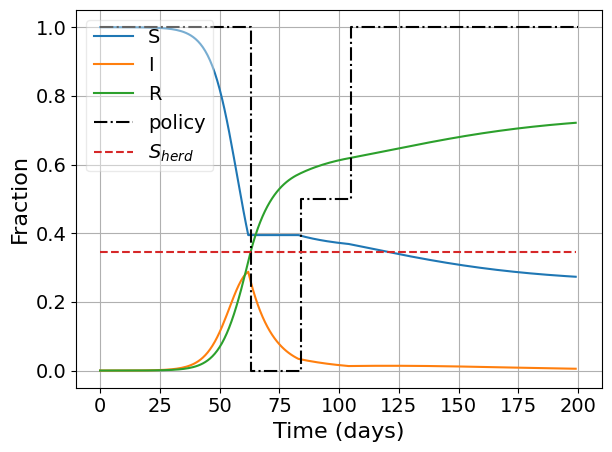

time: 1.9 s (started: 2024-06-03 04:15:07 +00:00)


In [ ]:
# # start policy compelete lockdown at day 60
# S0 = 67000 - 1
# I0 = 1
# county_pop = 67000
# county_area = 1
# beta=0.29
# gamma=0.1
# T= 200
# delta_t = 21
# policy = [1.0, 1.0, 1.0, 0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0]
# # policy = [1.0, 1.0, 1.0, 0.5, 0, 1.0, 1.0, 1.0, 1.0, 1.0]
# # policy = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]

# cost_min,S,I,R,_,_ = evaluate_cost_single(S0, I0, county_pop, county_area,
#                                       policy,delta_t,T=T,
#                                       beta =beta,gamma=gamma,
#                                       kappa = 0, eta = 1)
# plt.figure()
# plt.plot(S/67000,label='S')
# plt.plot(I/67000,label='I')
# plt.plot(R/67000,label='R')
# x = [delta_t*i for i in range(len(policy))] + [T]
# plt.step(x,policy+[policy[-1]],label= 'policy',linestyle='dashdot',where='post',color ='k')
# plt.plot([gamma/beta]*T,'--',label=r'$S_{herd}$')
# plt.legend(ncol=1,loc='upper left',framealpha=0.4)
# plt.xlabel('Time (days)')
# plt.grid()
# plt.ylabel('Fraction')
# ax.set_xticks(np.arange(0, 200, 25))

# plt.tight_layout()
# # plt.title('End ratio = '+str(end_ratio))
# # new_path = os.path.join(PATH,"SingleCounty/optimal_policy_delta_t=20.pdf")
# new_path = os.path.join(PATH,'SingleCounty/flipped_policy_delta_t='+str(delta_t)+'.pdf')
# print(new_path)
# plt.savefig(new_path)
# # print('Final size:',S[-1]/67000)

### Figure 2b

Final size: 0.31224777326700964


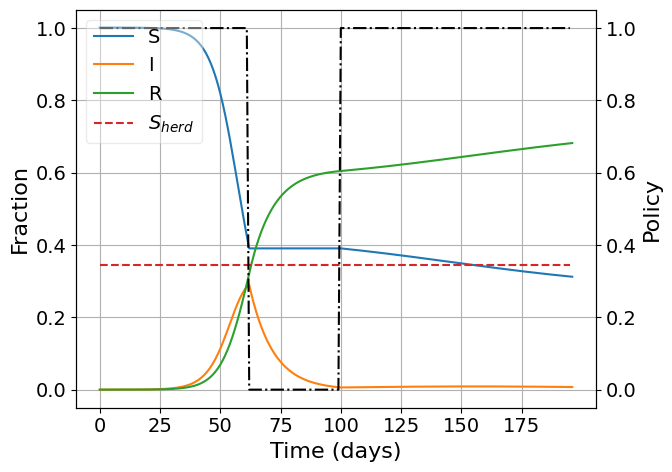

time: 1.08 s (started: 2024-07-14 17:56:26 +00:00)


In [139]:
# Bliman original
S1 = [6.710e7 - 1e3]
I1 = [1e3]
R1 = [0]
county_pop = 6.7e7
beta = 0.29
gamma = 0.1
policy=[]

for t in range(T):
  if t >=0 and t<62 or t >=100:
    alpha = 1
    policy.append(alpha)
  else:
    alpha = 0
    policy.append(alpha)

  S_new,I_new,R_new = update_SIR(S1[-1],I1[-1],R1[-1], alpha,county_pop, beta, gamma)
  S1.append(S_new)
  I1.append(I_new)
  R1.append(R_new)

fig,ax= plt.subplots(figsize=(7,5))
ax.plot([s/county_pop for s in S1],label='S')
ax.plot([i/county_pop for i in I1],label='I')
ax.plot([r/county_pop for r in R1],label='R')

ax.plot([gamma/beta]*T,'--',label=r'$S_{herd}$')
plt.legend(ncol=1,loc='upper left',framealpha=0.4)
plt.xlabel('Time (days)')
plt.grid()
ax.set_ylim(-0.05,1.05)
ax.set_ylabel('Fraction')
ax.set_xticks(np.arange(0, 200, 25))

ax2 = ax.twinx()
ax.plot(policy,label= 'policy',linestyle='dashdot',color ='k')
ax2.set_ylim(-0.05,1.05)
ax2.set_ylabel('Policy')

plt.tight_layout()
# new_path = os.path.join(PATH,"SingleCounty/optimal_policy_bliman.pdf")
# # print(new_path)

# plt.savefig(new_path)
print('Final size:',S1[-1]/county_pop)

In [23]:
# #bliman
# T = 200
# beta =0.291
# gamma=0.1
# plt.figure()
# # for i,delta_t in enumerate([7,14,21,28]):
# I_all = []
# optimal_policy_all = []
# delta_t = 20
# # kappa=1/50,eta=49/50
# kappa = 0
# eta = 1
# for end_ratio in [0.5]:
#   optimal_policy,cost_min, S,I,R,_,_ = multi_county_search(T=T,
#                                                         delta_t=delta_t,
#                                                         S0 = [67000 - 1]*2,
#                                                         I0 = [1]*2,
#                                                         end_ratio = end_ratio,
#                                                         county_pop = [67000]*2,
#                                                         county_area = [1]*2,
#                                                         kappa=kappa,eta=eta,
#                                                         beta =beta,
#                                                         gamma=gamma,
#                                                         reach_hi=False,
#                                                         intensity_max=0,
#                                                         modification=True,
#                                                         verbose=False)

#   # x = [delta_t*i for i in range(len(optimal_policy))] + [T]
#   # y = list(optimal_policy) + [optimal_policy[-1]]
#   # I_all.append(I)
#   # optimal_policy_all.append(optimal_policy)
#   # plt.figure()
#   # plt.plot(S[0,:]/67000,label='S')
#   # plt.plot(I[0,:]/67000,label='I')
#   # plt.plot(R[0,:]/67000,label='R')
#   # plt.step(x,y,label= 'policy',linestyle='dashdot',where='post')
#   # plt.plot([gamma/beta]*T,'--',label=r'$S_{herd}$',color ='k')
#   # plt.legend(ncol=2,loc='best')
#   # plt.title('End ratio = '+str(end_ratio))
#   # ax.grid()
#   # plt.show()

In [22]:
  # x = [delta_t*i for i in range(len(optimal_policy))] + [T]
  # y = list(optimal_policy) + [optimal_policy[-1]]
  # I_all.append(I)
  # optimal_policy_all.append(optimal_policy)
  # plt.figure()
  # plt.plot(S[0,:]/67000,label='S')
  # plt.plot(I[0,:]/67000,label='I')
  # plt.plot(R[0,:]/67000,label='R')
  # plt.step(x,y,label= 'policy',linestyle='dashdot',where='post')
  # plt.plot([gamma/beta]*T,'--',label=r'$S_{herd}$',color ='k')
  # plt.legend(ncol=2,loc='best')
  # plt.title('End ratio = '+str(end_ratio))
  # ax.grid()
  # plt.show()

### Los Angeles Second wave

i0 0.00013
r0 0.1
start_grid: 6
start date: 42.0
end_grid: 14
end date: 98.0
Optimal policy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Min cost: 0.5653416469242466
implementation cost: 0
impact cost: 0.5653416469242466
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
19.6
Implementation cost: 19.6
Normalized Implementation cost: 0.1
Impact cost: 0.2826708234621233


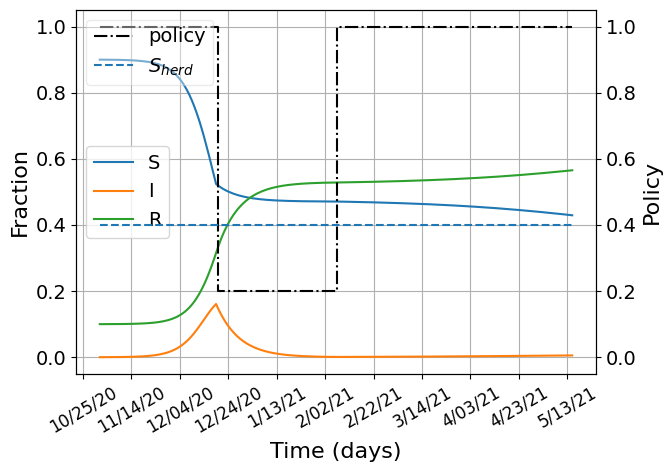

i0 0.00013
r0 0.2
start_grid: 6
start date: 42.0
end_grid: 14
end date: 98.0
Optimal policy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6, 0.2, 0.2, 0.2, 0.2, 0.2, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Min cost: 0.5956658992176527
implementation cost: 0
impact cost: 0.5956658992176527
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6, 0.2, 0.2, 0.2, 0.2, 0.2, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
15.400000000000002
Implementation cost: 15.400000000000002
Normalized Implementation cost: 0.07857142857142858
Impact cost: 0.29783294960882634


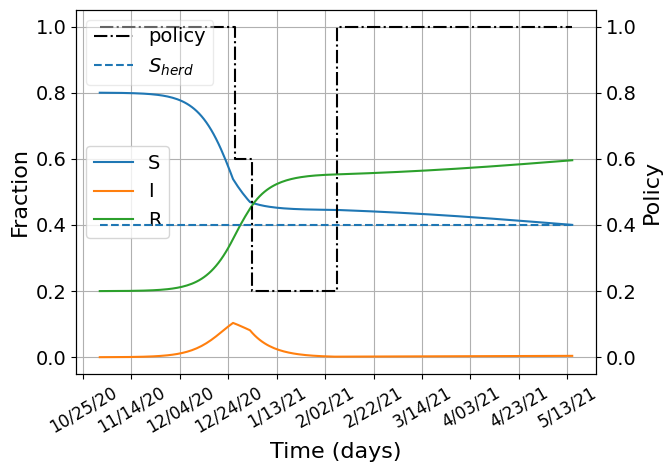

i0 0.00013
r0 0.3
start_grid: 6
start date: 42.0
end_grid: 14
end date: 98.0
Optimal policy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6, 0.2, 0.2, 0.2, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Min cost: 0.6374886998245399
implementation cost: 0
impact cost: 0.6374886998245399
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6, 0.2, 0.2, 0.2, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
9.8
Implementation cost: 9.8
Normalized Implementation cost: 0.05
Impact cost: 0.31874434991226996


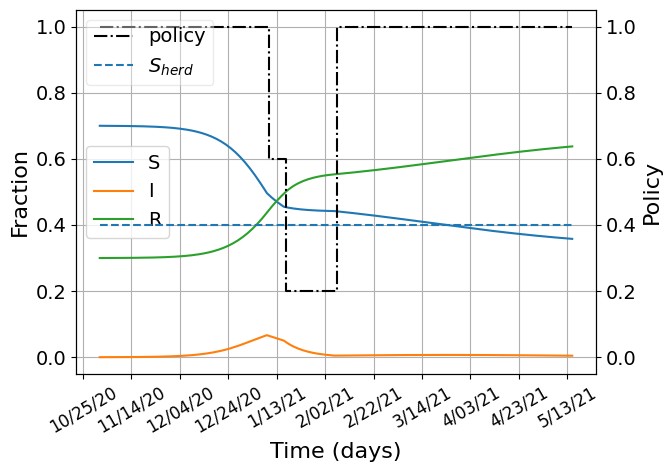

time: 28.2 s (started: 2024-07-15 02:21:28 +00:00)


In [257]:
# la
T = 196
R0 = 2.5 # 2.15
gamma=0.14
beta = R0*gamma
delta_t = 7
# kappa= 0.635
# eta= 1-kappa
# kappa= 0.25
kappa = 0
eta= 1-kappa

i0 = 1.3*1e-4
#2.38*1e-4
# r0 = (4.65 + (3.18 - 0.0657)*gamma)*1e-2
# r0 = 3.7*1e-2
for r0 in [0.1,0.2, 0.3]:
  # for i0 in [1.3*1e-4 ,2*1.3*1e-4 ,4*1.3*1e-4,8*1.3*1e-4]:
  print('i0',round(i0,6))
  print('r0',r0)
  s0 = 1 - i0 - r0

  start_ratio = delta_t*6/T
  end_ratio = 98/T

  county_pop = 10.04e6
  county_area = 1

  optimal_policy,cost_min, S,I,R,implementation_cost, impact_cost,count = single_county_search(T=T,
                                                                                          delta_t=delta_t,
                                                                                          S0 = county_pop*s0,
                                                                                          I0 = county_pop*i0,
                                                                                          start_ratio = start_ratio,
                                                                                          end_ratio = end_ratio,
                                                                                          county_pop = county_pop,
                                                                                          county_area = county_area,
                                                                                          kappa=kappa,eta=eta,
                                                                                          beta =beta,gamma=gamma,
                                                                                        intensity_max=0.2,
                                                                                          reach_hi=True,
                                                                                          herd_dist=3e-2,
                                                                                          # herd_dist=1e-4,
                                                                                          modification=True,
                                                                                          verbose=False,to_infinity=False)

  print(optimal_policy)
  cost = 0
  for alpha in optimal_policy:
    cost += 1/2*(1-alpha)*delta_t
  print(cost)
  cost /=delta_t*len(optimal_policy)
  print('Implementation cost:',cost*T)
  print('Normalized Implementation cost:',cost)
  print('Impact cost:',1/2*R[-1]/county_pop)
  start = datetime.datetime.strptime("11/1/20", "%m/%d/%y")
  y = []
  for i in range(len(optimal_policy)):
    y += [optimal_policy[i]]*delta_t
  fig,ax= plt.subplots(figsize=(7, 5))
  xx= [start + datetime.timedelta(days=x) for x in range(T)]
  ax.plot(xx,S/county_pop,label='S')
  ax.plot(xx,I/county_pop,label='I')
  ax.plot(xx,R/county_pop,label='R')
  # ax.ticklabel_format(axis='y', style='sci', scilimits=(0,4))
  # ax.set_ylim((0,0.008))
  ax.grid()
  ax.set_ylabel('Fraction')
  ax.legend(loc='center left')
  ax.set_ylim(-0.05,1.05)
  plt.xticks(rotation = 30,fontsize=12)
  plt.xlabel('Time (days)')

  ax2 = ax.twinx()
  ax2.set_ylabel('Policy')
  ax2.set_ylim(-0.05,1.05)
  ax2.step(xx,y,label= 'policy',linestyle='dashdot',where = 'post',color ='k')
  ax2.xaxis.set_major_locator(plt.MaxNLocator(12))
  ax2.xaxis.set_major_formatter(mdates.DateFormatter('%-m/%d/%y'))

  # plt.step(x,y,label= 'policy',linestyle='dashdot',where='post',color ='k')
  plt.plot(xx,[gamma/beta]*len(xx),'--',label=r'$S_{herd}$')
  plt.legend(ncol=1,loc='upper left',framealpha=0.4)

  plt.tight_layout()
  new_path = os.path.join(PATH,'SingleCounty/la_R0='+str(R0)+'_r0='+str(r0)+'_delta_t='+str(delta_t)+'.pdf')
  # print(new_path)
  # plt.savefig(new_path,figsize=(7,5))
  plt.show()

# stay-at-home order, real data

In [67]:
path = '/content/drive/MyDrive/Research/PolicySIR/U.S._State_and_Territorial_Stay-At-Home_Orders__March_15__2020___August_15__2021_by_County_by_Day.csv'
df_policy= pd.read_csv(path)

<ipython-input-67-cb71a448c7fd>:2: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_policy= pd.read_csv(path)


time: 10.7 s (started: 2024-07-15 14:22:35 +00:00)


In [5]:
# df_policy.head()

In [68]:
# preprocess df
print(df_policy['Order_code'].unique())
print(df_policy['Stay_at_Home_Order_Recommendation'].unique())
print(df_policy['Source_of_Action'].unique())
# print(df_policy['Citation'].unique())
# change 'Stay_at_Home_Order_Recommendation' to numerical values
order_dict = {
              'Mandatory for all individuals':0,
              'Mandatory only for all individuals in certain areas of the jurisdiction':0.2,
              'Mandatory only for at-risk individuals in the jurisdiction':0.4,
              'Mandatory only for at-risk individuals in certain areas of the jurisdiction':0.6,
              'Advisory/Recommendation':0.8,
              'No order for individuals to stay home':1
              }
df_policy = df_policy.replace({'Stay_at_Home_Order_Recommendation': order_dict})
df_policy['date'] = pd.to_datetime(df_policy['date'],format='%m/%d/%Y')
# fill NaN with 5, no order
df_policy['Stay_at_Home_Order_Recommendation'] = df_policy['Stay_at_Home_Order_Recommendation'].fillna(1)

[7 1 6 2 3 5]
[nan 'Mandatory for all individuals' 'Advisory/Recommendation'
 'No order for individuals to stay home'
 'Mandatory only for all individuals in certain areas of the jurisdiction'
 'Mandatory only for at-risk individuals in the jurisdiction'
 'Mandatory only for at-risk individuals in certain areas of the jurisdiction']
[nan 'Official' 'Press Release' 'Off' 'News Media' 'Judicial Ruling'
 'official']
time: 1.24 s (started: 2024-07-15 14:22:52 +00:00)


In [69]:
df_policy

,State_Tribe_Territory,County_Name,FIPS_State,FIPS_County,date,Order_code,Stay_at_Home_Order_Recommendation,Express_Preemption,Source_of_Action,URL,Citation
0,AL,Autauga County,1,1,2020-03-15,7,1.0,NaN,NaN,NaN,NaN
1,AL,Autauga County,1,1,2020-03-16,7,1.0,NaN,NaN,NaN,NaN
2,AL,Autauga County,1,1,2020-03-17,7,1.0,NaN,NaN,NaN,NaN
3,AL,Autauga County,1,1,2020-03-18,7,1.0,NaN,NaN,NaN,NaN
4,AL,Autauga County,1,1,2020-03-19,7,1.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1677922,VI,St. Thomas Island,78,30,2021-08-11,6,0.8,Unknown,Official,https://www.vi.gov/wp-content/uploads/2020/08/...,"V.I. Sixteenth Supp. Exec. Order (Sept. 8, 2020)"
1677923,VI,St. Thomas Island,78,30,2021-08-12,6,0.8,Unknown,Official,https://www.vi.gov/wp-content/uploads/2020/08/...,"V.I. Sixteenth Supp. Exec. Order (Sept. 8, 2020)"
1677924,VI,St. Thomas Island,78,30,2021-08-13,6,0.8,Unknown,Official,https://www.vi.gov/wp-content/uploads/2020/08/...,"V.I. Sixteenth Supp. Exec. Order (Sept. 8, 2020)"
1677925,VI,St. Thomas Island,78,30,2021-08-14,6,0.8,Unknown,Official,https://www.vi.gov/wp-content/uploads/2020/08/...,"V.I. Sixteenth Supp. Exec. Order (Sept. 8, 2020)"


time: 26.2 ms (started: 2024-07-15 14:23:19 +00:00)


In [70]:
def plot_real_policy(df_policy, county, state, plot=True,start_date=None, end_date=None,save=False):
  df_county = df_policy[(df_policy['County_Name'] == county) & (df_policy['State_Tribe_Territory'] == state)]
  df_county = df_county.sort_values(by='date')
  # print(df_county.head())
  if start_date and end_date:
      df_county = df_county[(df_county['date'] >= start_date) & (df_county['date'] <= end_date)]
  if plot:
    fig, ax = plt.subplots(figsize=(7, 5))
    # at = AnchoredText('0: Mandatory for all individuals\n1:Mandatory only for all individuals in certain areas of the jurisdiction', prop=dict(size=15), frameon=True, loc='upper left')
    # at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    # ax.add_artist(at)
    # print(df_county['date'])

    # print(df_county.head())
    plt.plot(df_county['date'], df_county['Stay_at_Home_Order_Recommendation'],label=county)
    # plt.ylim((0,6))
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%-m/%d/%y'))
    plt.xticks(rotation = 30,fontsize=12)
    plt.title('Stay-at-home policy',fontsize=BIGGER_SIZE)
    plt.legend()
    if save:
      new_path = os.path.join(PATH,"policy_cali_real.eps")
      print(new_path)
    #   plt.savefig(new_path,figsize=(7,5))
  return df_county

time: 935 µs (started: 2024-07-15 14:23:21 +00:00)


In [71]:
df_ca = df_policy[df_policy['State_Tribe_Territory'] == 'CA']
df_ca['date'] = pd.to_datetime(df_ca['date'],format='%m/%d/%Y')
# print(df_ca['County_Name'].unique())

time: 162 ms (started: 2024-07-15 14:23:22 +00:00)


<ipython-input-71-17a7c99c4061>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ca['date'] = pd.to_datetime(df_ca['date'],format='%m/%d/%Y')


In [72]:
# plot LA county
df_la = df_ca[df_ca['County_Name'] == 'Los Angeles County']
# df_la=df_la.replace({'Stay_at_Home_Order_Recommendation': order_dict})
df_sf = df_ca[df_ca['County_Name'] == 'San Francisco County']
# df_sf=df_sf.replace({'Stay_at_Home_Order_Recommendation': order_dict})
df_oc = df_ca[df_ca['County_Name'] == 'Orange County']
# df_oc=df_oc.replace({'Stay_at_Home_Order_Recommendation': order_dict})

time: 25.1 ms (started: 2024-07-15 14:23:26 +00:00)


In [73]:
for order in order_dict:
  print(order,order_dict[order])
  # print()

Mandatory for all individuals 0
Mandatory only for all individuals in certain areas of the jurisdiction 0.2
Mandatory only for at-risk individuals in the jurisdiction 0.4
Mandatory only for at-risk individuals in certain areas of the jurisdiction 0.6
Advisory/Recommendation 0.8
No order for individuals to stay home 1
time: 5.29 ms (started: 2024-07-15 14:23:27 +00:00)


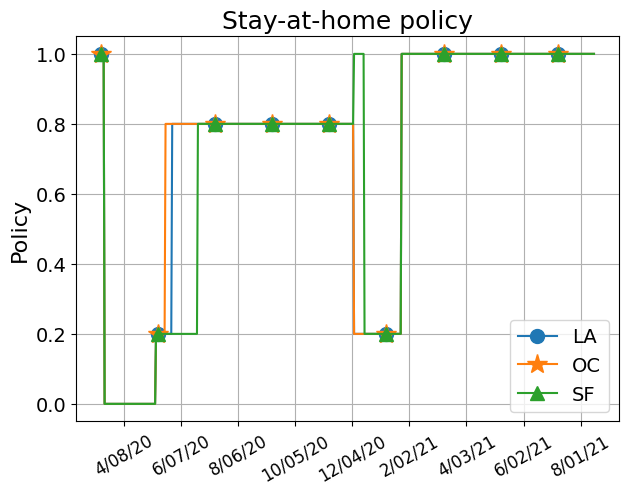

time: 733 ms (started: 2024-07-15 14:23:45 +00:00)


In [75]:
df_oc = df_oc.sort_values(by='date')
df_sf = df_sf.sort_values(by='date')
df_la = df_la.sort_values(by='date')
from matplotlib.offsetbox import AnchoredText
fig, ax = plt.subplots(figsize=(7, 5))
# at = AnchoredText('0: Mandatory for all individuals\n1:Mandatory only for all individuals in certain areas of the jurisdiction', prop=dict(size=15), frameon=True, loc='upper left')
# at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
# ax.add_artist(at)
plt.plot(df_la['date'], df_la['Stay_at_Home_Order_Recommendation'],label='LA',marker="o",markevery=60,markersize=10)
plt.plot(df_oc['date'], df_oc['Stay_at_Home_Order_Recommendation'],label='OC',marker="*",markevery=60,markersize=15)
plt.plot(df_sf['date'], df_sf['Stay_at_Home_Order_Recommendation'],label='SF',marker="^",markevery=60,markersize=10)
# plt.ylim((0,6))
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%-m/%d/%y'))
plt.xticks(rotation = 30,fontsize=12)
plt.title('Stay-at-home policy',fontsize=BIGGER_SIZE)
plt.legend()
plt.ylabel('Policy')
# plt.xlabel('Time (days)')
ax.grid()
# new_path = os.path.join(PATH,"policy_cali_real.eps")
# print(new_path)
# plt.savefig(new_path,figsize=(7,5))

In [ ]:
df_policy[(df_policy['State_Tribe_Territory'] == 'NY')]['County_Name'].unique()

array(['Albany County', 'Madison County', 'Monroe County',
       'Montgomery County', 'Nassau County', 'New York County',
       'Allegany County', 'Niagara County', 'Oneida County',
       'Onondaga County', 'Ontario County', 'Orange County',
       'Orleans County', 'Oswego County', 'Otsego County',
       'Putnam County', 'Queens County', 'Rensselaer County',
       'Richmond County', 'Rockland County', 'Bronx County',
       'St. Lawrence County', 'Saratoga County', 'Schenectady County',
       'Schoharie County', 'Broome County', 'Schuyler County',
       'Seneca County', 'Steuben County', 'Suffolk County',
       'Sullivan County', 'Cattaraugus County', 'Tioga County',
       'Tompkins County', 'Ulster County', 'Warren County',
       'Washington County', 'Wayne County', 'Westchester County',
       'Wyoming County', 'Yates County', 'Cayuga County',
       'Chautauqua County', 'Chemung County', 'Chenango County',
       'Clinton County', 'Columbia County', 'Cortland County',
   

time: 475 ms (started: 2022-06-22 17:26:14 +00:00)


# Covid, real data

In [13]:
PATH = '/content/drive/MyDrive/Research/PolicySIR/figure'
#confirmed cases
url_c = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv"
confirmed_data = pd.io.parsers.read_csv(url_c)

#death
url_d = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv"
death_data = pd.io.parsers.read_csv(url_d)

#13 th column is the first day

data_CA = confirmed_data.loc[confirmed_data["Province_State"] == "California"]

In [14]:
data_CA.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
197,84006001,US,USA,840,6001.0,Alameda,California,US,37.646294,-121.892927,...,401161,401161,401161,401161,401161,401161,401161,402158,402158,402160
198,84006003,US,USA,840,6003.0,Alpine,California,US,38.596786,-119.822359,...,143,143,143,143,143,143,143,143,143,143
199,84006005,US,USA,840,6005.0,Amador,California,US,38.445831,-120.656960,...,11540,11540,11540,11540,11540,11540,11540,11553,11553,11553
200,84006007,US,USA,840,6007.0,Butte,California,US,39.667278,-121.600525,...,51916,51916,51916,51916,51916,51916,51916,51967,51967,51967
201,84006009,US,USA,840,6009.0,Calaveras,California,US,38.205371,-120.552913,...,9634,9634,9634,9634,9634,9634,9634,9650,9650,9650


In [15]:
# death_la = death_data.loc[confirmed_data["Admin2"] == "Los Angeles"]
# print(death_la.loc[:,'10/25/20':'11/5/20'])
# 7074/(1.88*1e-2)/(10.04*1e6)

In [16]:
# data_CA.loc[:,'3/15/20':'8/15/21']

In [17]:
def plot_covid_data(df, county,state, county_pop, start_date='3/14/20', end_date='8/15/21'):
  data_county = df.loc[(df["Province_State"] == state) &(df["Admin2"] == county)]
  # print(data_county.head())
  fig, ax = plt.subplots(figsize=(7, 5))
  # sns.set_theme(style="whitegrid")
  # print(data_county.loc[:,start_date:end_date].diff(axis=1))
  # print(data_county.loc[:,start_date:end_date].rolling(7, min_periods=1).mean().diff(axis=1))
  # print(type(data_county.loc[:,start_date:end_date].rolling(7, min_periods=1).mean()))
  print('Cumulative:',data_county.loc[:,start_date:end_date].rolling(7,axis=1).mean()/county_pop)
  data = data_county.loc[:,start_date:end_date].rolling(7,axis=1).mean().diff(axis=1)/county_pop

  # remove negative data
  data[data<=0] = 0
  # data.dropna()
  print(data.head())
  sns.lineplot(data=data.iloc[0,1:], palette="tab10", linewidth=2.5,label = county)
  ax.xaxis.set_major_locator(plt.MaxNLocator(12))
  plt.xticks(rotation = 30,fontsize=12)
  # ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
  plt.title('Daily incresed cases percentage',fontsize=BIGGER_SIZE)
  plt.ylabel('Infected percentage')
  plt.ticklabel_format(axis='y', style='sci', scilimits=(0,4))
  plt.legend(fontsize=SMALL_SIZE)
  return data_county

In [18]:
# covid_la = plot_covid_data(confirmed_data, 'Los Angeles','California', 1.04e7,start_date= '3/20/20',end_date = '11/1/20')

In [19]:
# plot_covid_data(confirmed_data, 'New York','New York', 8.38e6)

In [20]:
# def plot_covidnpolicy(df,df_policy, county,state, county_pop, start_date='3/14/20', end_date='8/15/21'):
#   # plot policy
#   df_county_policy = df_policy[(df_policy['County_Name'] == county) & (df_policy['State_Tribe_Territory'] == state)]
#   df_county_policy = df_county_policy.sort_values(by='date')
#   # print(df_county.head())
#   fig, ax = plt.subplots(figsize=(7, 5))
#   # print(df_county['date'])

#   plt.plot(df_county_policy['date'], df_county_policy['Stay_at_Home_Order_Recommendation'],label=county)
#   # plt.ylim((0,6))
#   ax.xaxis.set_major_locator(plt.MaxNLocator(10))
#   ax.set_ylabel('Policy')
#   ax.xaxis.set_major_formatter(mdates.DateFormatter('%-m/%d/%y'))
#   plt.xticks(rotation = 30,fontsize=12)
#   # plt.title('Stay-at-home policy',fontsize=BIGGER_SIZE)

#   #   plt.savefig(new_path,figsize=(7,5))
#   # return df_county
#   ax2 = ax.twinx()
#   ax2.set_ylabel('Infected percentage')
#   data_county = df.loc[(df["Province_State"] == state) &(df["Admin2"] == county)]
#   # print(data_county.head())

#   data = data_county.loc[:,start_date:end_date].rolling(7,axis=1).mean().diff(axis=1)/county_pop
#   print(data.head())
#   # remove negative data
#   data[data<=0] = 0
#   # data.dropna()
#   print(data.head())
#   ax2 = sns.lineplot(data=data.iloc[0,1:], palette="tab10", linewidth=2.5,label = county)
#   ax2.xaxis.set_major_locator(plt.MaxNLocator(12))
#   plt.xticks(rotation = 30,fontsize=12)
#   # ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
#   plt.title('Daily incresed cases percentage and policy',fontsize=BIGGER_SIZE)
#   ax2.ticklabel_format(axis='y', style='sci', scilimits=(0,4))
#   plt.legend(fontsize=SMALL_SIZE)
#   if save:
#     new_path = os.path.join(PATH,"policy_cali_real.eps")
#     print(new_path)

In [21]:
# df_policy[ (df_policy['State_Tribe_Territory'] == 'WA')]['County_Name'].unique()

In [22]:
# confirmed_data.loc[(confirmed_data["Province_State"] == 'Washington')]['Admin2'].unique()

3/11/20         NaN
3/12/20         NaN
3/13/20         NaN
3/14/20         NaN
3/15/20         NaN
3/16/20         NaN
3/17/20         NaN
3/18/20    0.000002
3/19/20    0.000003
3/20/20    0.000003
Name: 215, dtype: float64


<ipython-input-25-cf5c40b3a74c>:16: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=data, palette="tab10", linewidth=2.5,label = 'Los Angeles',marker="o",markevery=80,markersize=12)
<ipython-input-25-cf5c40b3a74c>:20: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=data, palette="tab10", linewidth=2.5,label = 'Orange',marker='*',markevery=80,markersize=20)
<ipython-input-25-cf5c40b3a74c>:24: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=data, palette="tab10", linewidth=2.5,label = 'San Francisco',marker='^',markevery=80,markersize=13)


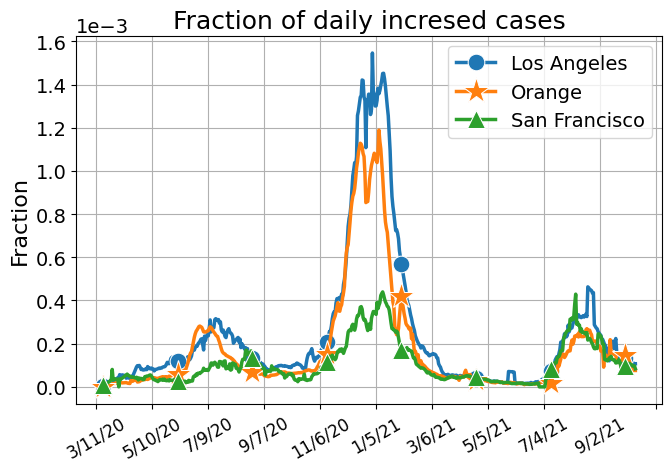

In [25]:
fig, ax = plt.subplots(figsize=(7, 5))
# sns.set_theme(style="whitegrid")
ax.grid()
# cities = ['Orange','Ventura','Tehama','San Luis Obispo']
cities = ['San Francisco','Orange','Los Angeles']
confirmed_city = data_CA[data_CA.Admin2.isin(cities)]
confirmed_city
# plt.plot(confirmed_city.iloc[0,11:-1].diff(),label = 'San Luis Obispo')
# # plt.plot(confirmed_city.iloc[0,11:-1],label = 'Orange')
# plt.plot(confirmed_city.iloc[1,11:-1].diff(),label = 'Tehama')
# plt.plot(confirmed_city.iloc[2,11:-1].diff(),label = 'Ventura')
end_idx = 639#-310
data = confirmed_city.iloc[0,60:end_idx].rolling(7).mean().diff()/1.04e7
data[data<=0] = 0
print(data[:10])
sns.lineplot(data=data, palette="tab10", linewidth=2.5,label = 'Los Angeles',marker="o",markevery=80,markersize=12)
data = confirmed_city.iloc[1,60:end_idx].rolling(7).mean().diff()/3.176e6
data[data<=0] = 0
# print(data[10:20])
sns.lineplot(data=data, palette="tab10", linewidth=2.5,label = 'Orange',marker='*',markevery=80,markersize=20)
data = confirmed_city.iloc[2,60:end_idx].rolling(7).mean().diff()/874961
data[data<=0] = 0
# print(data[10:20])
sns.lineplot(data=data, palette="tab10", linewidth=2.5,label = 'San Francisco',marker='^',markevery=80,markersize=13)
# plt.plot(confirmed_city.iloc[2,60:-150].rolling(7).mean().diff()/874961,label = 'San Francisco')
# plt.plot(confirmed_city.iloc[1,60:-150].rolling(7).mean().diff()/3.176e6,label = 'Orange')
# plt.plot(confirmed_city.iloc[0,60:-150].rolling(7).mean().diff()/1.04e7,label = 'Los Angeles')
ax.xaxis.set_major_locator(plt.MaxNLocator(12))
plt.xticks(rotation = 30,fontsize=12)
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
# plt.title('Daily incresed cases percentage',fontsize=BIGGER_SIZE)
plt.title('Fraction of daily incresed cases',fontsize=BIGGER_SIZE)
plt.ylabel('Fraction')
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,4))
plt.legend(fontsize=SMALL_SIZE)
plt.tight_layout()
new_path = os.path.join(PATH,"I_cali_real.eps")
# plt.savefig(new_path,figsize=(7,5))